# T cell figures

## Inputs

In [1]:
source('jupyterFunctions_perCellType.R')

In [2]:
CT <- 'Tcell'
CT_label <- 'T cell'
data_prefix <- paste(sep='','../data/',CT,'/',CT)
ATAC_meta <- readRDS(paste(sep='',data_prefix,'_ATAC_meta.rds'))
chosenPeaks <- readRDS(paste(sep='',data_prefix,'_chosenPeaks.rds'))
diffPeaks <- readRDS(paste(sep='',data_prefix,'_diffPeaks.rds'))
diffGenes <- readRDS(paste(sep='',data_prefix,'_diffGenes.rds'))
snATAC_pxc_norm <- readRDS(paste(sep='',data_prefix,'_snATAC_pxc_norm.rds'))
snRNA_gxc_norm <- readRDS(paste(sep='',data_prefix,'_snRNA_gxc_norm.rds'))
snATAC_pxCT_norm <- readRDS(paste(sep='',data_prefix,'_snATAC_pxCT_norm.rds'))
snRNA_gxCT_norm <- readRDS(paste(sep='',data_prefix,'_snRNA_gxCT_norm.rds'))
chromVARz_mat <- readRDS(paste(sep='',data_prefix,'_ArchR_chromVARz_JASPAR2020.rds'))
ArchR_padj <- readRDS(paste(sep='',data_prefix,'_ArchR_padj_JASPAR2020.rds'))
CITE_meta <- readRDS(paste(sep='',data_prefix,'_CITE_meta.rds'))
class_state_df <- readRDS(paste(sep='',data_prefix,'_class_state_df.rds'))
LDA_res <- readRDS(paste(sep='',data_prefix,'_LDA_stats.rds'))
other_resol <- readRDS(paste(sep='',data_prefix,'_ATAC_otherRes.rds'))
CNA_TB <- readRDS(paste(sep='',data_prefix,'_CNA_CTAP-TB.rds'))
CNA_KI <- readRDS(paste(sep='',data_prefix,'_CNA_Krenn.rds'))

lineage_res <- readRDS(paste(sep='',data_prefix,'_CD4_CD8_lineage_betas.rds'))
ATAC_pxc_norm <- readRDS(paste(sep='',data_prefix,'_ATAC_pxc_norm.rds'))

snATAC_pxCITE_norm <- readRDS(paste(sep='',data_prefix,'_snATAC_pxCITE_norm.rds'))
snRNA_gxCITE_norm <- readRDS(paste(sep='',data_prefix,'_snRNA_gxCITE_norm.rds'))

LDA_sim <- readRDS(paste(sep='',data_prefix,'_LDA_AUROC_T13_T14.rds'))
LDA_dif <- readRDS(paste(sep='',data_prefix,'_LDA_AUROC_T3_T14.rds'))

In [3]:
ATAC_colors <- readRDS('../data/misc/ATAC_class_colors.rds')
CITE_colors <- readRDS('../data/misc/CITE_state_colors.rds')
ATAC_CITE_conv_df <- readRDS('../data/misc/ATAC_CITE_sample_conversion.rds')

In [35]:
save_dir <- NA #'../output_v14/' #or NA if don't want to save
file_extension <- '.pdf'
data_extension <- '_sourceData.txt'

## ATAC classes

In [5]:
#setting class order
class_order <- c('TA-0','TA-4','TA-1','TA-2','TA-3')
all(class_order %in% ATAC_meta$cluster_abbr)

class_conv_df <- unique(ATAC_meta[,c('cluster_name','cluster_abbr')])
rownames(class_conv_df) <- class_conv_df$cluster_abbr
full_class_order <- class_conv_df[class_order,'cluster_name']

[1] TRUE

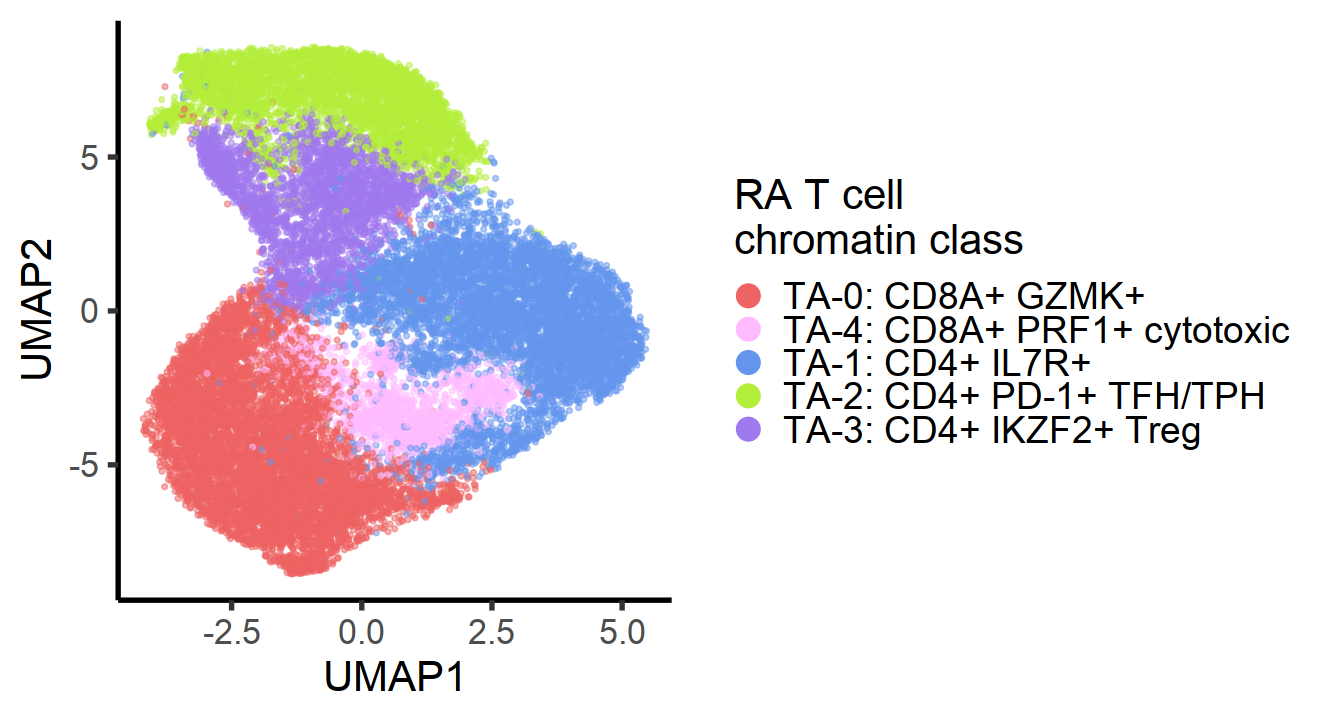

In [6]:
#Fig 2a

options(repr.plot.height=6,repr.plot.width=11)
toPlot <- ATAC_meta[,c('UMAP1','UMAP2','cluster_name')]
toPlot$cluster_name <- factor(toPlot$cluster_name,levels=full_class_order)
g <- ggplot(toPlot,aes_string(x='UMAP1',y='UMAP2',color='cluster_name')) + geom_point(size=1,alpha=0.5) + 
        theme_classic(base_size=25) + scale_color_manual(values=ATAC_colors) + 
        labs(color=paste(sep='','RA ',CT_label,'\nchromatin class')) + 
        theme(legend.text=element_text(size=22)) + 
        guides(colour = guide_legend(override.aes = list(size=6,alpha=1)))
print(g)

colnames(toPlot) <- c('UMAP1','UMAP2',paste('RA',CT_label,'chromatin class'))

if(!is.na(save_dir)){
    ggsave(file=paste(sep='',save_dir,CT,'_ATAC_class_UMAP',file_extension),
           plot=g,units='in',height=6,width=11,dpi=600)
    write.table(toPlot,paste(sep='',save_dir,CT,'_ATAC_class_UMAP',data_extension),
                sep='\t',col.name=TRUE,row.name=FALSE,quote=FALSE)
}

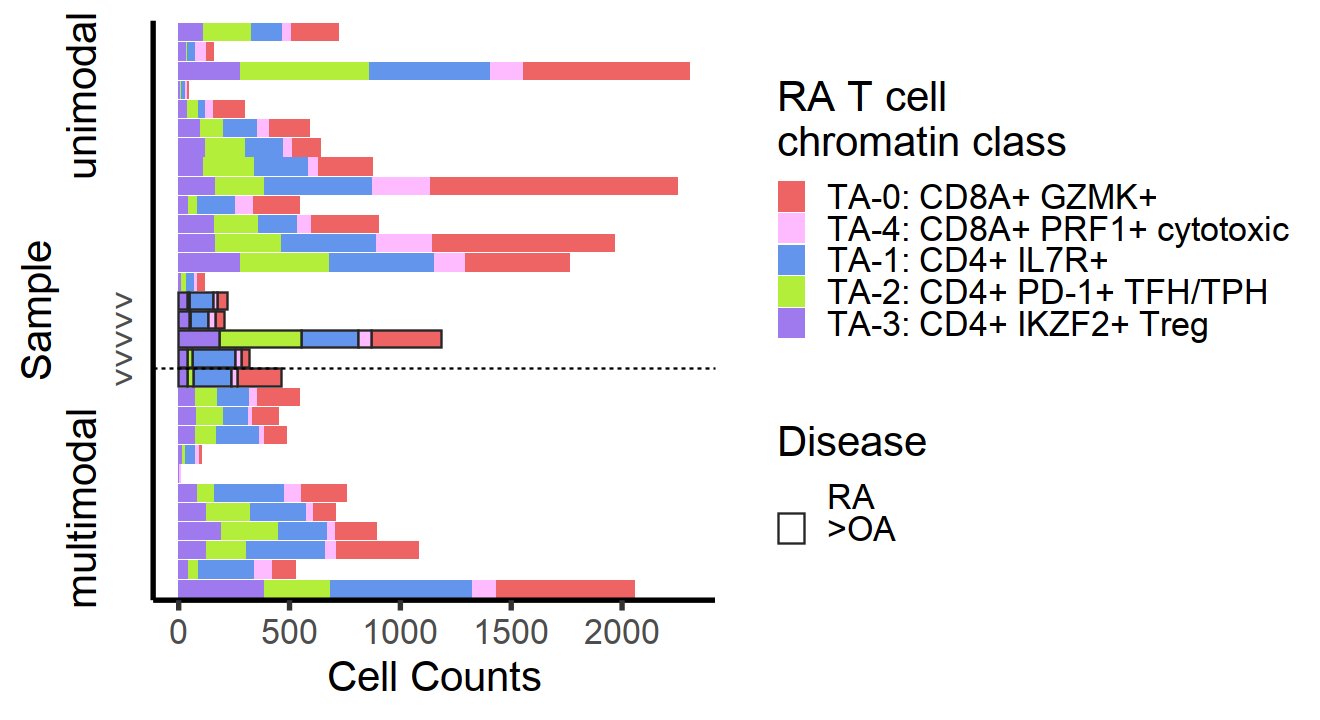

In [7]:
#Fig S3a

options(repr.plot.height=6,repr.plot.width=11)
r <- cellCount_bySample_barPlot(ATAC_meta,'sample','cluster_name',paste(sep='','RA ',CT_label,'\nchromatin class'),
                                ATAC_colors,res_order=full_class_order)
g <- r$plot
df <- r$data
print(g)

if(!is.na(save_dir)){
    ggsave(file=paste(sep='',save_dir,CT,'_ATAC_class_cellCount',file_extension),
           plot=g,units='in',height=6,width=11,dpi=600)
    write.table(df,paste(sep='',save_dir,CT,'_ATAC_class_cellCount',data_extension),
                sep='\t',col.name=TRUE,row.name=FALSE,quote=FALSE)
}

In [8]:
#Table S6

toSave <- table(ATAC_meta[,c('cluster_name','disease')])
toSave

if(!is.na(save_dir)) write.table(toSave,sep='\t',col.names=T,row.names=T,quote=F,
                                 file=paste(sep='',save_dir,CT,'_ATAC_class_disease_cellCount.txt'))

                             disease
cluster_name                    OA   RA
  TA-0: CD8A+ GZMK+            637 6736
  TA-1: CD4+ IL7R+             805 5763
  TA-2: CD4+ PD-1+ TFH/TPH     432 3934
  TA-3: CD4+ IKZF2+ Treg       357 2736
  TA-4: CD8A+ PRF1+ cytotoxic  164 1604

## ATAC cluster markers

In [9]:
chosenGenes <- names(chosenPeaks)
chosenPeaks <- chosenPeaks[!is.na(chosenPeaks)] #NA means no peak in gene's promoter

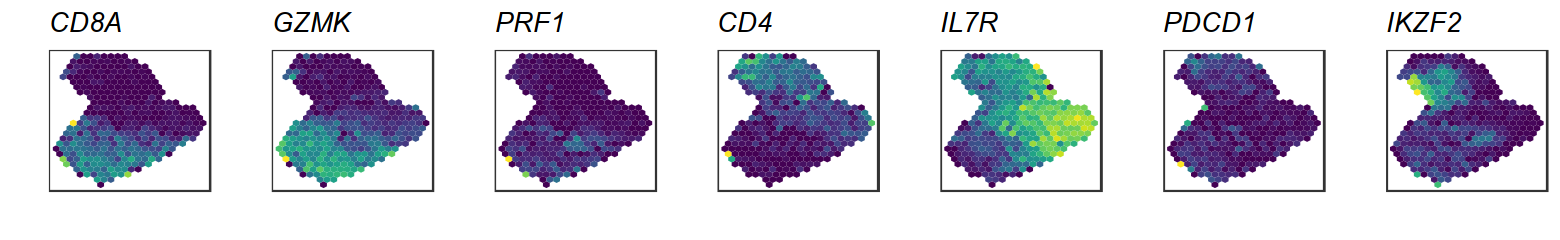

In [10]:
#Fig 2b bottom

genes_forUMAPs <- c('CD8A','GZMK','PRF1','CD4','IL7R','PDCD1','IKZF2')
if(!all(genes_forUMAPs %in% names(chosenPeaks))) stop('Genes for UMAP not in chosen genes')

multiome_cells <- rownames(ATAC_meta[which(ATAC_meta$assay=='snATAC'),])

options(repr.plot.height=2,repr.plot.width=13)
g <- plot_markerPeaks_norm_hex_v2(ATAC_meta[multiome_cells,],snRNA_gxc_norm[genes_forUMAPs,multiome_cells],'UMAP1','UMAP2',
                                  plot_genes=genes_forUMAPs,plotCol=length(genes_forUMAPs),
                                  titleSize=16,hex_bins=21,cutCap=0)
grid.draw(g)
if(!is.na(save_dir)) ggsave(file=paste(sep='',save_dir,CT,'_markerGene_UMAP',file_extension),
                            plot=g,units='in',height=2,width=13,dpi=600)

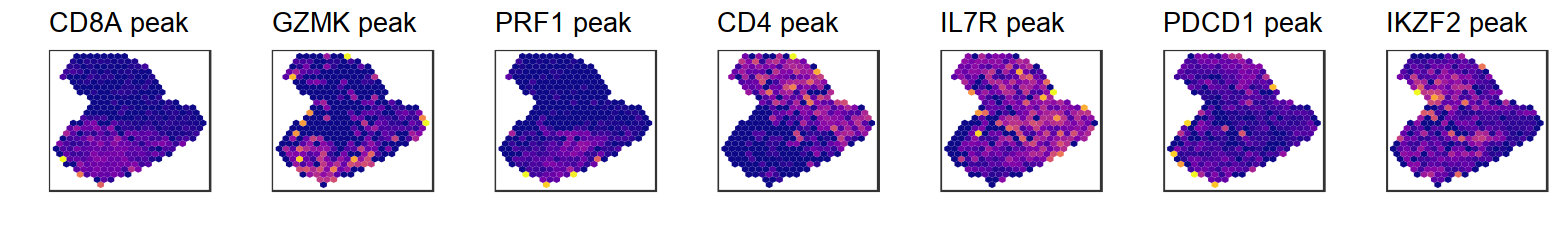

In [11]:
#Fig 2b top

toPlot <- snATAC_pxc_norm[unname(chosenPeaks[genes_forUMAPs]),multiome_cells] 
rownames(toPlot) <- paste(sep='',names(chosenPeaks[genes_forUMAPs]),' peak')

options(repr.plot.height=2,repr.plot.width=13)
g <- plot_markerPeaks_norm_hex_v2(ATAC_meta[multiome_cells,],toPlot,'UMAP1','UMAP2',
                                  plot_genes=rownames(toPlot),plotCol=nrow(toPlot),titleSize=16,hex_bins=21,cutCap=0,
                                  titleFace='plain',colorOpt='plasma')
grid.draw(g)
if(!is.na(save_dir)) ggsave(file=paste(sep='',save_dir,CT,'_markerPeak_UMAP',file_extension),
                            plot=g,units='in',height=2,width=13,dpi=600)

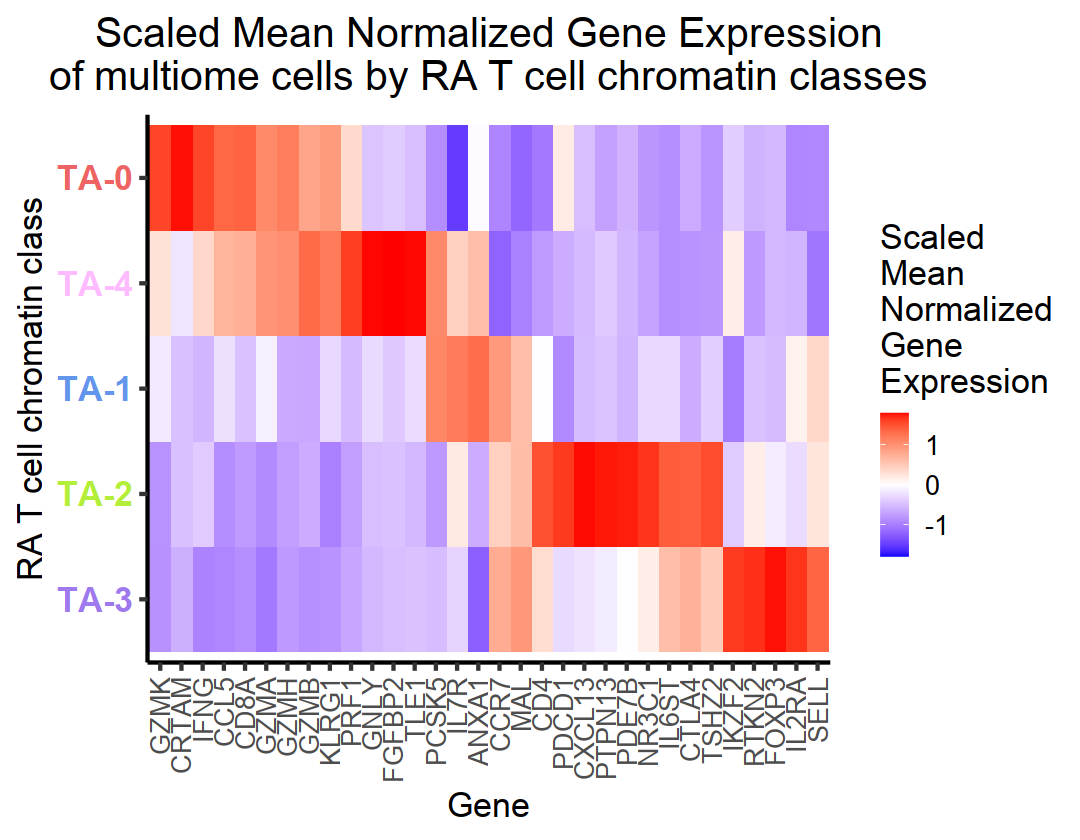

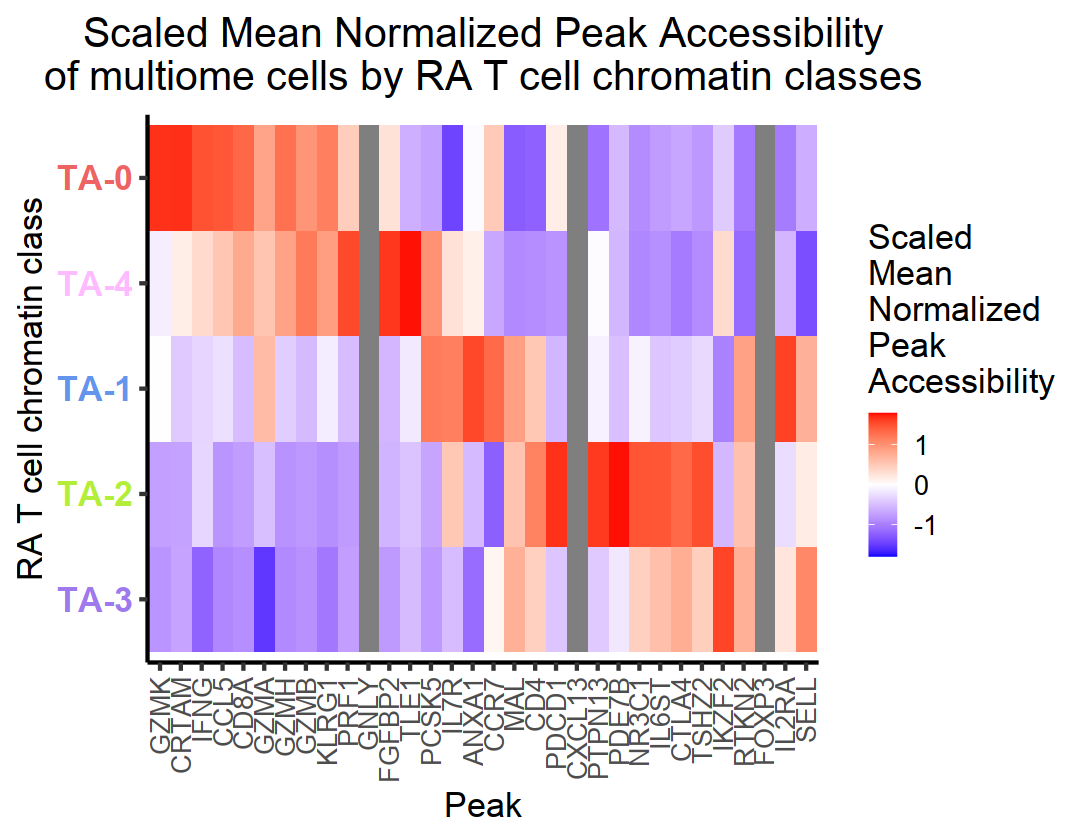

Comparing 145 gene/class combinations


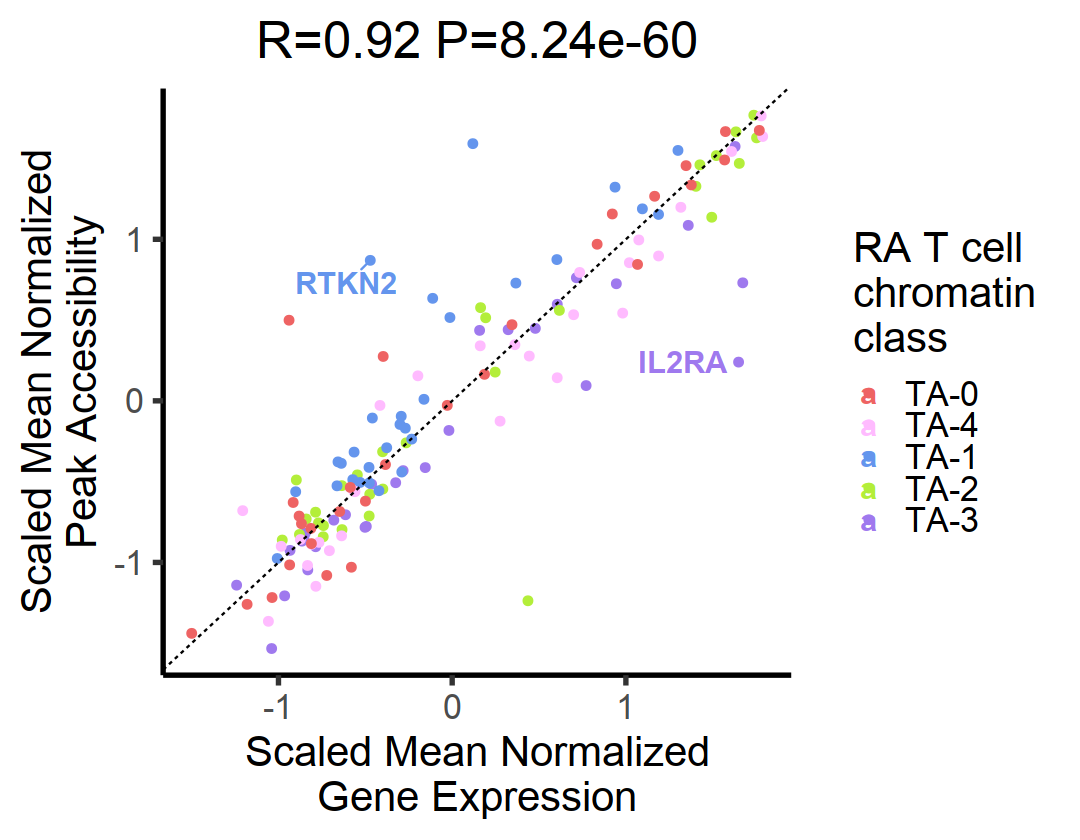

In [12]:
#Fig S3b

res <- scaleFeat_forHeatmap(chosenGenes,class_order,chosenPeaks,snRNA_gxCT_norm,snATAC_pxCT_norm)
snRNA_gxCT_norm_subset_scaled <- res$gxCT_norm_subset_scaled
snATAC_pxCT_norm_subset_scaled <- res$pxCT_norm_subset_scaled
fxCT_norm_subset_scaled <- res$fxCT_norm_subset_scaled

scale_lim <- max(abs(snRNA_gxCT_norm_subset_scaled),abs(snATAC_pxCT_norm_subset_scaled),na.rm=TRUE)

options(repr.plot.height=7,repr.plot.width=9)
g <- pseudobulk_scaled_heatmap(snRNA_gxCT_norm_subset_scaled,'Gene',paste('RA',CT_label,'chromatin class'),
                               'Scaled\nMean\nNormalized\nGene\nExpression',
                               plotTit=paste('Scaled Mean Normalized Gene Expression\nof multiome cells by RA',
                                             CT_label,'chromatin classes'),
                               scale_lim=scale_lim,clustColors=ATAC_colors)
print(g)
if(!is.na(save_dir)) ggsave(file=paste(sep='',save_dir,CT,'_markerGene_heatmap',file_extension),
                            plot=g,units='in',height=7,width=9,dpi=600)

g <- pseudobulk_scaled_heatmap(snATAC_pxCT_norm_subset_scaled,'Peak',paste('RA',CT_label,'chromatin class'),
                               'Scaled\nMean\nNormalized\nPeak\nAccessibility',
                               plotTit=paste('Scaled Mean Normalized Peak Accessibility\nof multiome cells by RA',
                                             CT_label,'chromatin classes'),
                               scale_lim=scale_lim,clustColors=ATAC_colors)
print(g)
if(!is.na(save_dir)) ggsave(file=paste(sep='',save_dir,CT,'_markerPeak_heatmap',file_extension),
                            plot=g,units='in',height=7,width=9,dpi=600)

pearR <- cor.test(fxCT_norm_subset_scaled$gene_norm_scale,fxCT_norm_subset_scaled$peak_norm_scale,
               method='pearson')

fxCT_norm_subset_scaled$label <- ''
fxCT_norm_subset_scaled[which(fxCT_norm_subset_scaled$gene=='RTKN2' & fxCT_norm_subset_scaled$cluster_abbr=='TA-1'),
                        'label'] <- 'RTKN2'
fxCT_norm_subset_scaled[which(fxCT_norm_subset_scaled$gene=='IL2RA' & fxCT_norm_subset_scaled$cluster_abbr=='TA-3'),
                        'label'] <- 'IL2RA'

fxCT_norm_subset_scaled$cluster_abbr <- factor(fxCT_norm_subset_scaled$cluster_abbr,levels=class_order)
g <- ggplot(fxCT_norm_subset_scaled,
            aes_string(x='gene_norm_scale',y='peak_norm_scale',color='cluster_abbr',label='label')) + 
        geom_point(size=2) + theme_classic(base_size=25) + scale_color_manual(values=ATAC_colors) + 
        labs(x='Scaled Mean Normalized\nGene Expression',
             y='Scaled Mean Normalized\nPeak Accessibility',
             color=paste(sep='','RA ',CT_label,'\nchromatin\nclass')) +
        geom_abline(slope=1,intercept=0,linetype='dashed') + 
        ggtitle(paste(sep='','R=',round(pearR$estimate,2),' P=',signif(pearR$p.value,3))) + 
        theme(plot.title=element_text(hjust = 0.5)) + geom_text_repel(box.padding = 0.5,size=6.5,fontface='bold',seed=0) 
suppressWarnings(print(g)) #points excluded if peak does not exist
cat(paste('Comparing',nrow(fxCT_norm_subset_scaled[which(!is.na(fxCT_norm_subset_scaled$peak_norm_scale)),]),
          'gene/class combinations\n'))

df <- fxCT_norm_subset_scaled[,c('gene','cluster_abbr','gene_norm_scale','peak_norm_scale')]
colnames(df) <- c('Gene',paste('RA',CT_label,'chromatin class'),
                  'Scaled Mean Normalized Gene Expression','Scaled Mean Normalized Peak Accessibility')

if(!is.na(save_dir)){
    suppressWarnings(ggsave(file=paste(sep='',save_dir,CT,'_markerGenePeak_scatterplot',file_extension),
                            plot=g,units='in',height=7,width=9,dpi=600))
    write.table(df,paste(sep='',save_dir,CT,'_markerGenePeak_scatterplot',data_extension),
                sep='\t',col.name=TRUE,row.name=FALSE,quote=FALSE)
}

## Single cell differential features

In [13]:
#Table S9

sc_diffFeat_df <- get_differential_features(diffPeaks,diffGenes,unique(ATAC_meta[,c('cluster_abbr','cluster_name')]),
                                            snRNA_gxCT_norm_subset_scaled)
sc_diffFeat_df$class <- factor(sc_diffFeat_df$class,levels=rev(class_order))
toSave <- sc_diffFeat_df[order(sc_diffFeat_df$class,sc_diffFeat_df$peakPadj,decreasing=TRUE),]

if(!is.na(save_dir)) write.table(toSave,sep='\t',col.names=T,row.names=F,quote=F,
                                 file=paste(sep='',save_dir,CT,'_diffFeat.txt'))

## CD4/CD8 Lineage Score

In [14]:
#Table S3

if(!identical(rownames(ATAC_meta),colnames(ATAC_pxc_norm))) stop('cell order is different')

lineage_df <- data.frame('cluster_abbr'=ATAC_meta$cluster_abbr,
                         'CD4_peak'=ATAC_pxc_norm[unname(chosenPeaks['CD4']),],
                         'CD8A_peak'=ATAC_pxc_norm[unname(chosenPeaks['CD8A']),],
                         stringsAsFactors=FALSE)

lineage_df$lineage <- 0
lineage_df[which(lineage_df$CD4_peak!=0 & lineage_df$CD8A_peak==0),'lineage'] <- 1
lineage_df[which(lineage_df$CD4_peak==0 & lineage_df$CD8A_peak!=0),'lineage'] <- -1

toSave <- table(lineage_df[,c('cluster_abbr','lineage')])
toSave

if(!is.na(save_dir)) write.table(toSave,sep='\t',col.names=T,row.names=T,quote=F,
                                 file=paste(sep='',save_dir,CT,'_lineage_cellCounts.txt'))

            lineage
cluster_abbr   -1    0    1
        TA-0 1526 5763   84
        TA-1  391 5584  593
        TA-2  120 3645  601
        TA-3   35 2847  211
        TA-4  319 1421   28

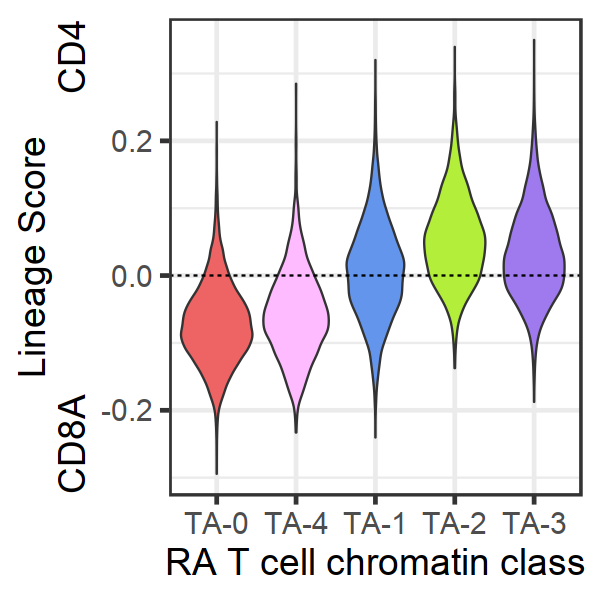

In [15]:
#Fig S3d & Table S4

fdr_cutoff <- 0.2

toSave <- lineage_res[which(lineage_res$LRT_padj<fdr_cutoff),]
if(!is.na(save_dir)) write.table(toSave[order(toSave$lineage_beta,decreasing=TRUE),],
                                 file=paste(sep='',save_dir,CT,'_lineage_scores.txt'),
                                 quote=FALSE,sep='\t',row.names=FALSE)

CD4_assoc_peaks <- lineage_res[which(lineage_res$LRT_padj<fdr_cutoff & lineage_res$lineage_beta>0),'peak']
CD8A_assoc_peaks <- lineage_res[which(lineage_res$LRT_padj<fdr_cutoff & lineage_res$lineage_beta<0),'peak']

perCell_scores <- perCell_score(ATAC_pxc_norm,CD4_assoc_peaks,CD8A_assoc_peaks)

toPlot <- cbind(ATAC_meta, 'lineage_score'=perCell_scores[rownames(ATAC_meta)])
toPlot$cluster_abbr <- factor(toPlot$cluster_abbr,levels=class_order)

options(repr.plot.height=5,repr.plot.width=5)
g <- ggplot(toPlot,aes_string(x='cluster_abbr',y='lineage_score',fill='cluster_name')) + geom_violin() + 
        theme_bw(base_size=22) + scale_fill_manual(values=ATAC_colors) + theme(legend.position="none") + 
        labs(x=paste('RA',CT_label,'chromatin class'),y='Lineage Score\nCD8A                              CD4') + 
        geom_hline(yintercept=0,linetype='dashed',color='black')
print(g)

if(!is.na(save_dir)) ggsave(file=paste(sep='',save_dir,CT,'_lineage_scores',file_extension),
                            plot=g,units='in',height=5,width=5,dpi=600)

## TFs

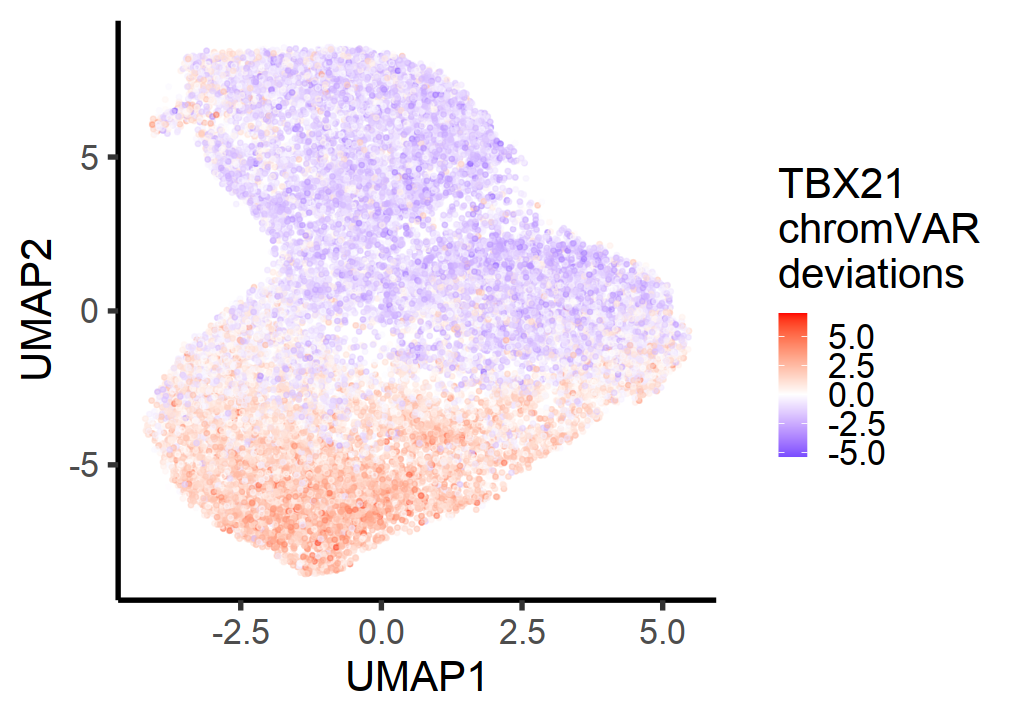

In [16]:
#Fig 2c left

if(!identical(sort(colnames(chromVARz_mat)),
              sort(rownames(ATAC_meta)))) stop('cellnames not consistent b/t ATAC_meta and chromVAR')

motif_toPlot <- 'TBX21_124'
toPlot <- cbind(ATAC_meta,'motif'=chromVARz_mat[motif_toPlot,rownames(ATAC_meta)])

options(repr.plot.height=6,repr.plot.width=8.5)
g <- ggplot(toPlot,aes_string(x='UMAP1',y='UMAP2',color='motif')) +  
        rasterise(geom_point(size=1,alpha=0.5),dpi=200) + 
        theme_classic(base_size=25) + scale_color_gradient2(low='blue',mid='white',high='red',midpoint=0) +
        labs(color=paste(sep='',str_split_fixed(motif_toPlot,'_',2)[,1],'\nchromVAR\ndeviations'))
print(g)

df <- toPlot[,c('UMAP1','UMAP2','motif')]
colnames(df) <- c('UMAP1','UMAP2',paste(str_split_fixed(motif_toPlot,'_',2)[,1],'chromVAR deviations'))

if(!is.na(save_dir)){
    ggsave(file=paste(sep='',save_dir,CT,'_motif_',motif_toPlot,'_UMAP',file_extension),
           plot=g,units='in',height=6,width=8.5,dpi=600)
    write.table(df,paste(sep='',save_dir,CT,'_motif_',motif_toPlot,'_UMAP',data_extension),
                sep='\t',col.name=TRUE,row.name=FALSE,quote=FALSE)
}

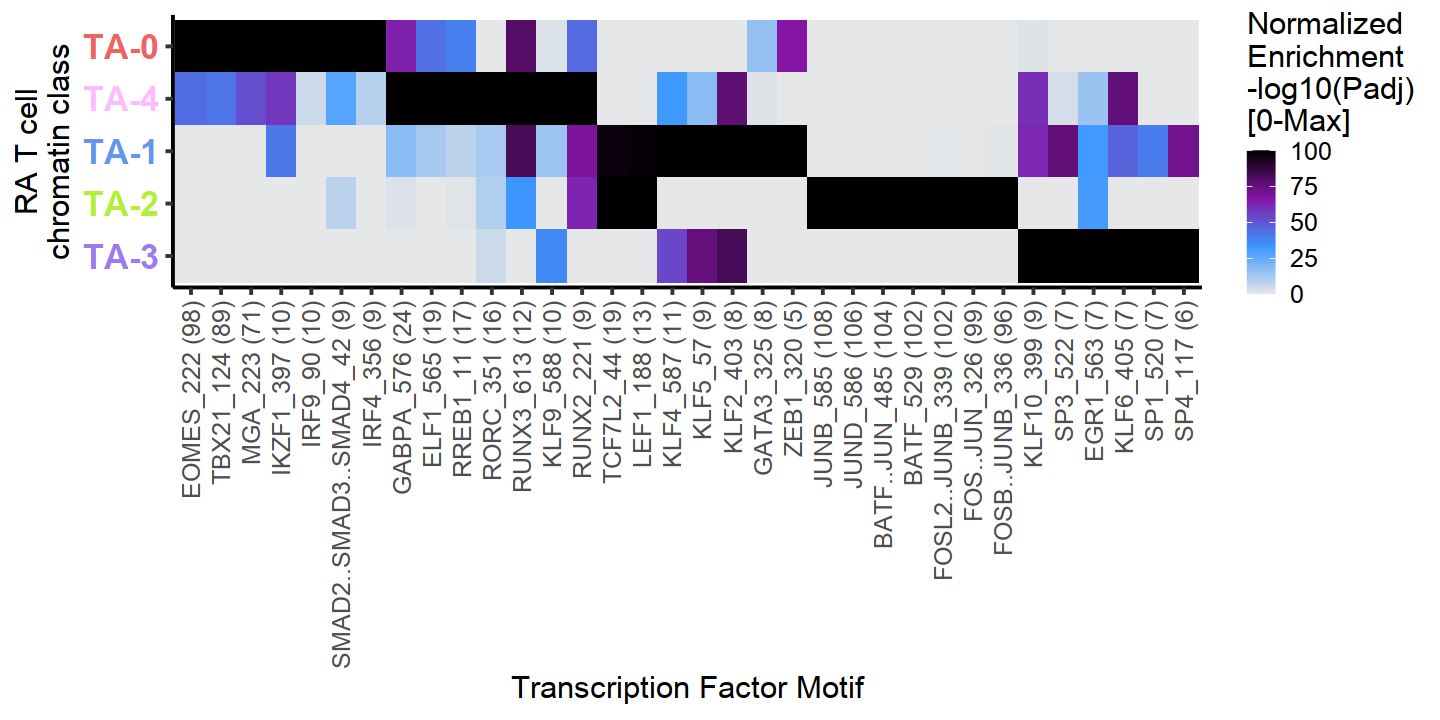

In [17]:
#Fig 2c right

if(!identical(sort(colnames(ArchR_padj)),
              sort(colnames(snRNA_gxCT_norm)))) stop('mxCT and gxCT matrices do not have same CT.')

motifs_res <- ArchR_topMotifs_KWspin(ArchR_padj,snRNA_gxCT_norm,cOrd=class_order,cColors=ATAC_colors,
                                     minE=5,num_mot=7,minGE=0.05,withinE=0.95, 
                                     mLab='Transcription Factor Motif',
                                     cLab=paste(sep='','RA ',CT_label,'\nchromatin class'))
g <- motifs_res$motE
top_motifs_df <- motifs_res$df
top_TFs_df <- motifs_res$TFdf

options(repr.plot.height=6,repr.plot.width=12)
print(g)

if(!is.na(save_dir)) ggsave(file=paste(sep='',save_dir,CT,'_motif_heatmap',file_extension),
                            plot=g,units='in',height=6,width=12,dpi=600)

In [18]:
#Table S5

top_TFs_df <- top_TFs_df[!duplicated(top_TFs_df$class_tf),]
tf_colors <- ATAC_colors[as.character(top_TFs_df$cluster_abbr)]
names(tf_colors) <- top_TFs_df$tf

tf_wilcox_df <- TF_exp_wilcox_cells_byClass(ATAC_meta,snRNA_gxc_norm,top_TFs_df,
                                            'cluster_abbr',paste(sep='','RA ',CT_label,' chromatin class'),
                                            cOrd=class_order,clustColors=ATAC_colors,motColors=tf_colors)

if(!is.na(save_dir)) write.table(tf_wilcox_df,file=paste(sep='',save_dir,CT,'_TFexp_byClass_WilcoxonFDR.txt'),
                                 quote=FALSE,sep='\t',row.names=FALSE)

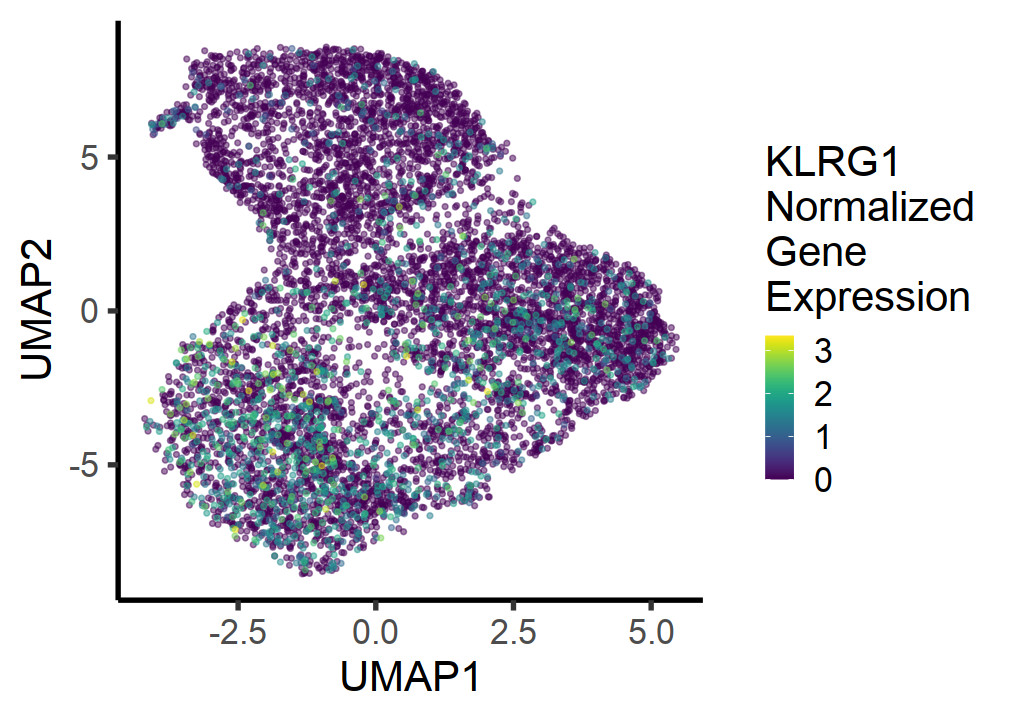

In [19]:
#Fig 2d left

gene_toPlot <- 'KLRG1'
toPlot <- cbind(ATAC_meta[multiome_cells,],'gene'=snRNA_gxc_norm[gene_toPlot,multiome_cells])

options(repr.plot.height=6,repr.plot.width=8.5)
g <- ggplot(toPlot[order(toPlot$gene),],aes_string(x='UMAP1',y='UMAP2',color='gene')) + 
                geom_point(size=1,alpha=0.5) + 
                theme_classic(base_size=25) + scale_color_viridis(option = 'viridis') + 
                labs(color=paste(sep='',gene_toPlot,'\nNormalized\nGene\nExpression'))
print(g)

df <- toPlot[,c('UMAP1','UMAP2','gene')]
colnames(df) <- c('UMAP1','UMAP2',paste(gene_toPlot,'Normalized Gene Expression'))

if(!is.na(save_dir)){
    ggsave(file=paste(sep='',save_dir,CT,'_gene_',gene_toPlot,'_UMAP',file_extension),
           plot=g,units='in',height=6,width=8.5,dpi=600)
    write.table(df,paste(sep='',save_dir,CT,'_gene_',gene_toPlot,'_UMAP',data_extension),
                sep='\t',col.name=TRUE,row.name=FALSE,quote=FALSE)
}

## Transcriptional Cell States

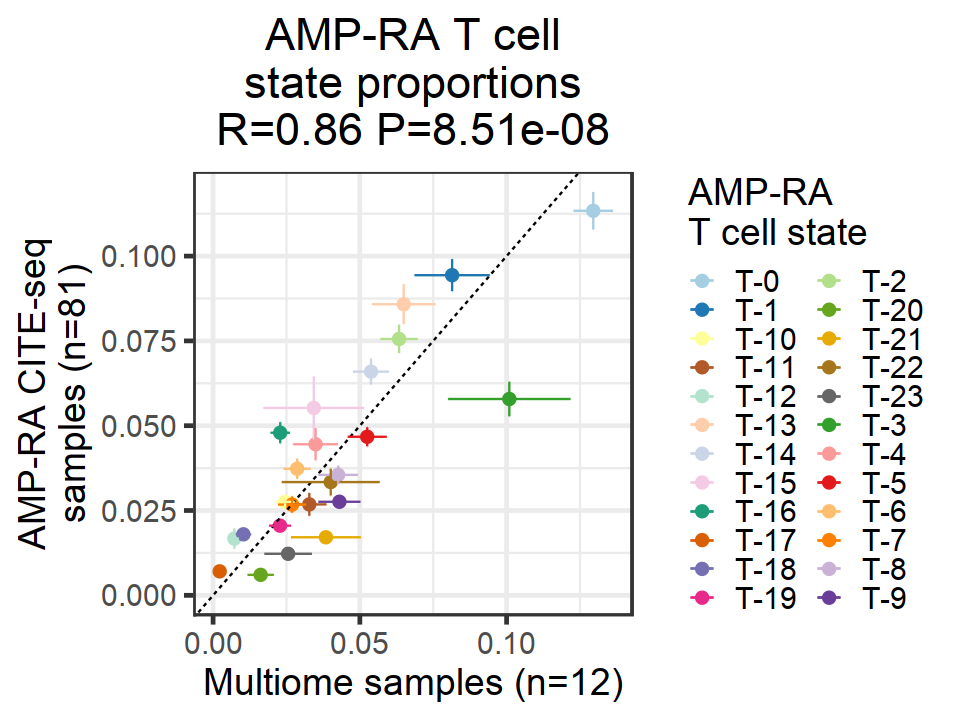

In [20]:
#Fig S10a

options(repr.plot.height=6,repr.plot.width=8)
r <- symp_prop_df(ATAC_meta[multiome_cells,],CITE_meta,
                  paste(sep='','Multiome samples (n=',
                        length(unique(ATAC_meta[multiome_cells,'sample'])),')'),
                  paste(sep='','AMP-RA CITE-seq\nsamples (n=',
                        length(unique(CITE_meta$sample)),')'),
                  paste(sep='','AMP-RA\n',CT_label,' state'),
                  tLab=paste(sep='','AMP-RA ',CT_label,'\nstate proportions\n'),
                  clustColors=CITE_colors)
g <- r$plot
df <- r$data
print(g)

if(!is.na(save_dir)){
    ggsave(file=paste(sep='',save_dir,CT,'_ATAC_CITE_state_prop',file_extension),
           plot=g,units='in',height=6,width=8,dpi=600)
    write.table(df,paste(sep='',save_dir,CT,'_ATAC_CITE_state_prop',data_extension),
                sep='\t',col.name=TRUE,row.name=FALSE,quote=FALSE)
}

In [21]:
#setting state order
class_state_df$class <- factor(class_state_df$class,levels=class_order)
state_order <- class_state_df[order(class_state_df$class,class_state_df$intOrd),'state']

state_conv_df <- unique(ATAC_meta[,c('CITE','CITE_abbr')])
rownames(state_conv_df) <- state_conv_df$CITE_abbr
full_state_order <- state_conv_df[state_order,'CITE']

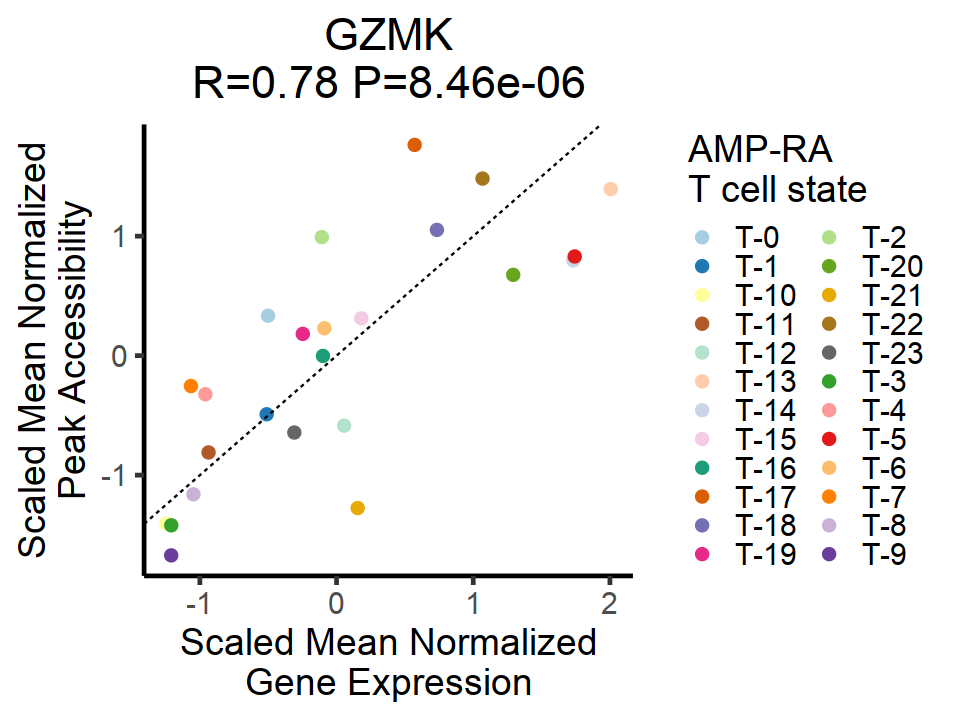

In [22]:
#Fig S10f

res <- scaleFeat_forHeatmap(chosenGenes,state_order,chosenPeaks,snRNA_gxCITE_norm,snATAC_pxCITE_norm)
snRNA_gxCITE_norm_subset_scaled <- res$gxCT_norm_subset_scaled
snATAC_pxCITE_norm_subset_scaled <- res$pxCT_norm_subset_scaled
fxCITE_norm_subset_scaled <- res$fxCT_norm_subset_scaled

scale_lim <- max(abs(snRNA_gxCITE_norm_subset_scaled),abs(snATAC_pxCITE_norm_subset_scaled),na.rm=TRUE)

toPlot <- fxCITE_norm_subset_scaled[which(fxCITE_norm_subset_scaled$gene=='GZMK'),]

pearR <- cor.test(toPlot$gene_norm_scale,toPlot$peak_norm_scale,method='pearson')

options(repr.plot.height=6,repr.plot.width=8)
g <- ggplot(toPlot,aes_string(x='gene_norm_scale',y='peak_norm_scale',color='cluster_abbr')) + 
        geom_point(size=3) + theme_classic(base_size=22) + scale_color_manual(values=CITE_colors) + 
        labs(x='Scaled Mean Normalized\nGene Expression',
             y='Scaled Mean Normalized\nPeak Accessibility',
             color=paste(sep='','AMP-RA\n',CT_label,' state')) +
        geom_abline(slope=1,intercept=0,linetype='dashed') + 
        ggtitle(paste(sep='','GZMK\nR=',round(pearR$estimate,2),' P=',signif(pearR$p.value,3))) + 
        theme(plot.title=element_text(hjust = 0.5))
print(g)

df <- toPlot[,c('cluster_abbr','gene_norm_scale','peak_norm_scale')]
colnames(df) <- c(paste('AMP-RA',CT_label,'state'),
                  'GZMK Scaled Mean Normalized Gene Expression','GZMK Scaled Mean Normalized Peak Accessibility')

if(!is.na(save_dir)){
    ggsave(file=paste(sep='',save_dir,CT,'_GZMK_GenePeak_scatterplot_byCITE',file_extension),
           plot=g,units='in',height=6,width=8,dpi=600)
    write.table(df,paste(sep='',save_dir,CT,'_GZMK_GenePeak_scatterplot_byCITE',data_extension),
                sep='\t',col.name=TRUE,row.name=FALSE,quote=FALSE)
}

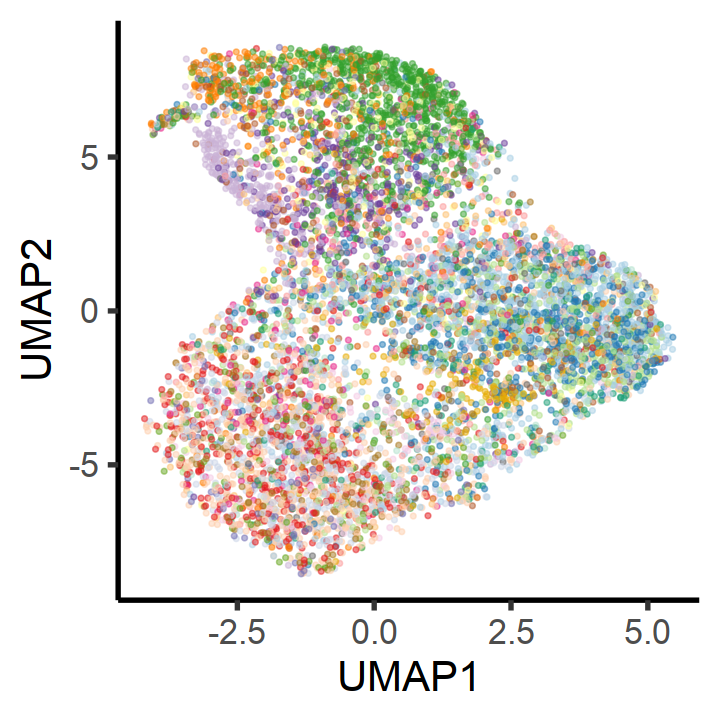

In [23]:
#Fig 7a left

options(repr.plot.height=6,repr.plot.width=6)
g <- ggplot(ATAC_meta[multiome_cells,],aes_string(x='UMAP1',y='UMAP2',color='CITE')) + 
        geom_point(size=1,alpha=0.5) + 
        theme_classic(base_size=25) + scale_color_manual(values=CITE_colors) + 
        theme(legend.position="none")
print(g)

df <- ATAC_meta[multiome_cells,c('UMAP1','UMAP2','CITE')]
colnames(df) <- c('UMAP1','UMAP2',paste('AMP-RA',CT_label,'state'))

if(!is.na(save_dir)){
    ggsave(file=paste(sep='',save_dir,CT,'_snATAC_state_UMAP',file_extension),
           plot=g,units='in',height=6,width=6,dpi=600)
    write.table(df,paste(sep='',save_dir,CT,'_snATAC_state_UMAP',data_extension),
                sep='\t',col.name=TRUE,row.name=FALSE,quote=FALSE)
}

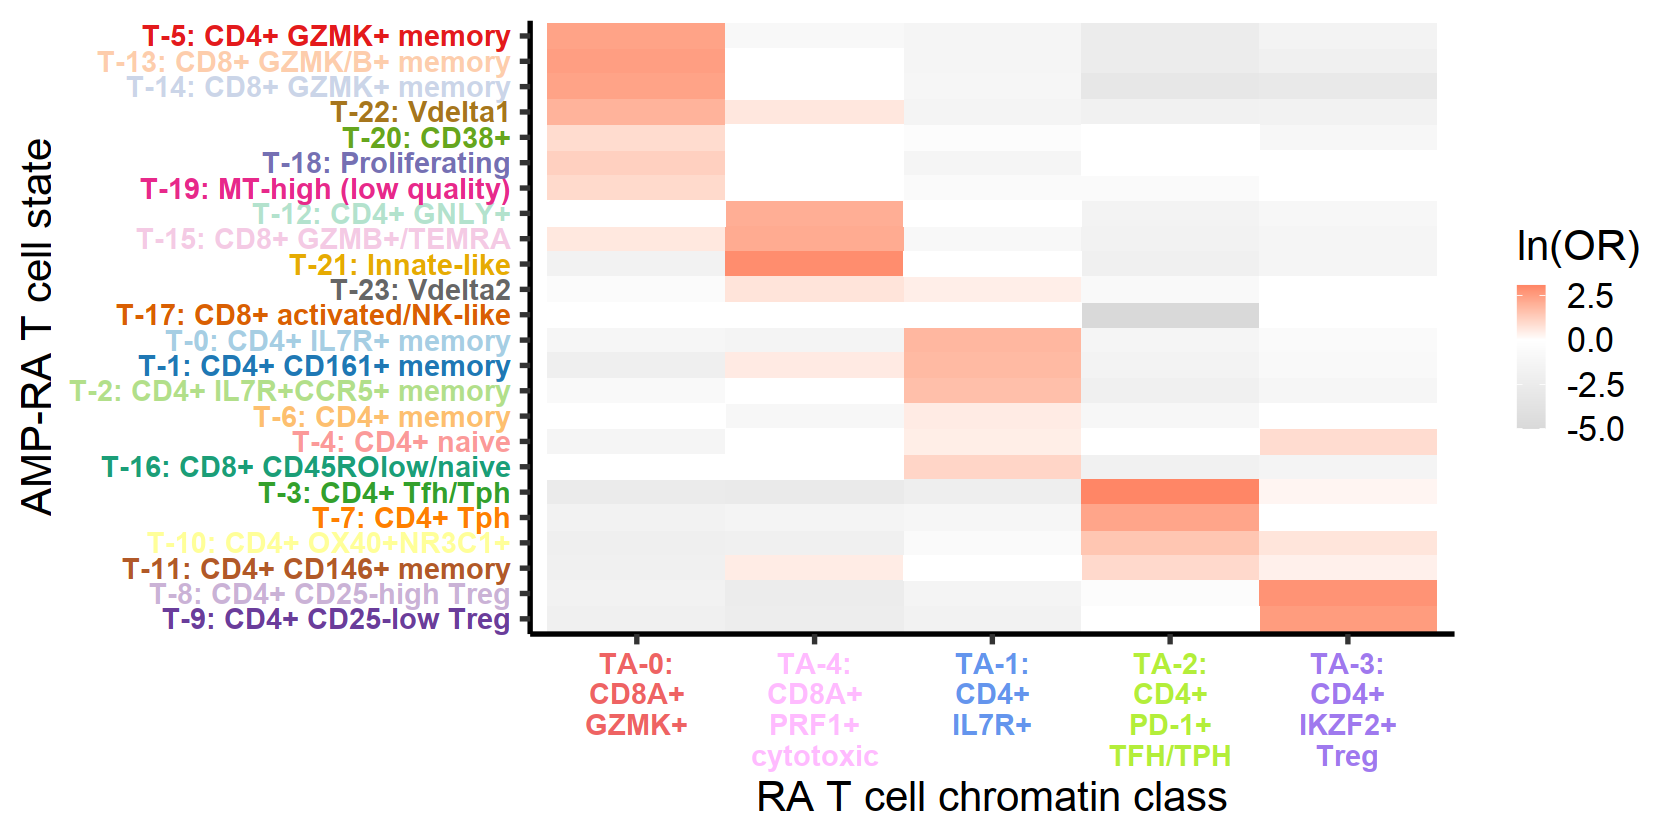

In [24]:
#Fig 7a right & Table S7

fisher_df <- calc_OR(ATAC_meta[multiome_cells,], 'cluster_name', 'CITE')
if(!is.na(save_dir)) write.table(fisher_df[,c('cluster_name','CITE','OR','pval','padj','CI_low','CI_high')],
                                 file=paste(sep='',save_dir,CT,'_class_state_OR_table.txt'),
                                 quote=FALSE,sep='\t',row.names=FALSE)

g <- plot_OR(fisher_df, 'cluster_name', 'CITE',
             paste('RA',CT_label,'chromatin class'), paste('AMP-RA',CT_label,'state'),
             full_class_order, full_state_order,
             clustColors=c(ATAC_colors,CITE_colors))

options(repr.plot.height=7,repr.plot.width=14)
print(g)

if(!is.na(save_dir)) ggsave(file=paste(sep='',save_dir,CT,'_class_state_OR_heatmap',file_extension),
                            plot=g,units='in',height=7,width=14,dpi=600)

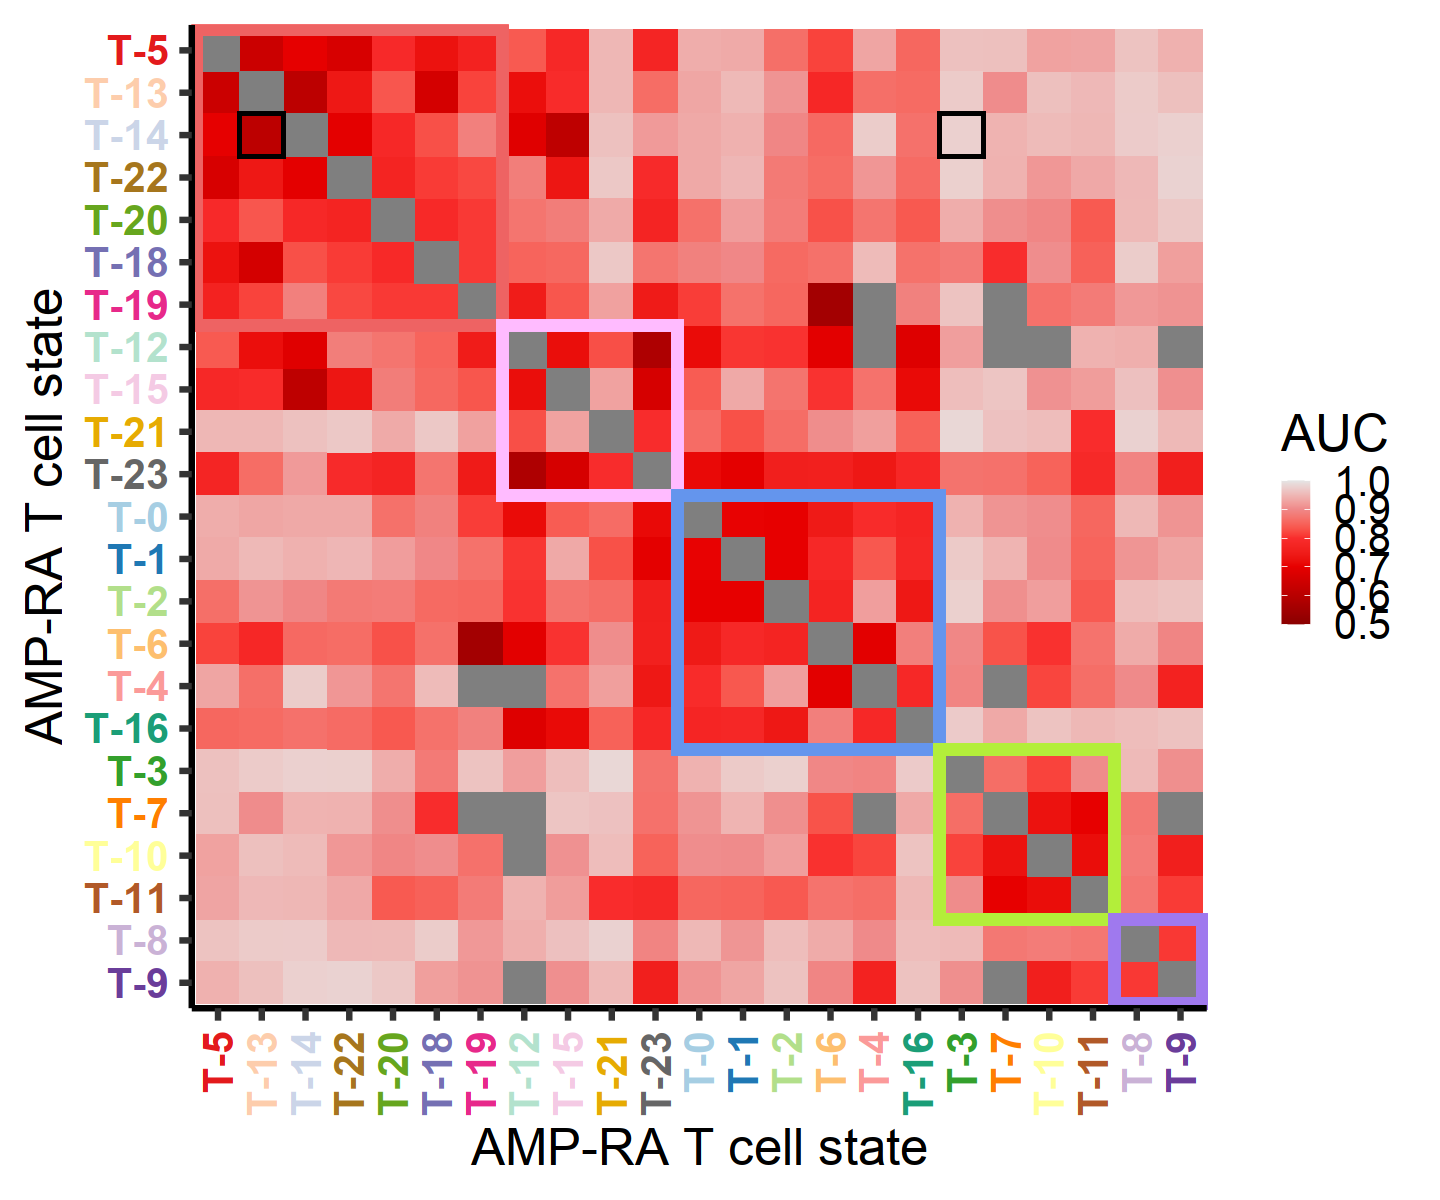

In [25]:
#Fig S14a

options(repr.plot.height=10,repr.plot.width=12)
g <- LDA_plots(LDA_res,CT,paste('AMP-RA',CT_label,'state'),
               class_state_df=class_state_df,ctOrd_col='intOrd',ctOrd=class_order,
               clustColors=c(CITE_colors,ATAC_colors))
g <- g + geom_rect(xmin=1.5, xmax=2.5, ymin=20.5, ymax=21.5,alpha=0,color='black',size=1) +
        geom_rect(xmin=17.5, xmax=18.5, ymin=20.5, ymax=21.5,alpha=0,color='black',size=1) 

print(g)

if(!is.na(save_dir)) ggsave(file=paste(sep='',save_dir,CT,'_LDA_heatmap',file_extension),
                            plot=g,units='in',height=10,width=12,dpi=600)

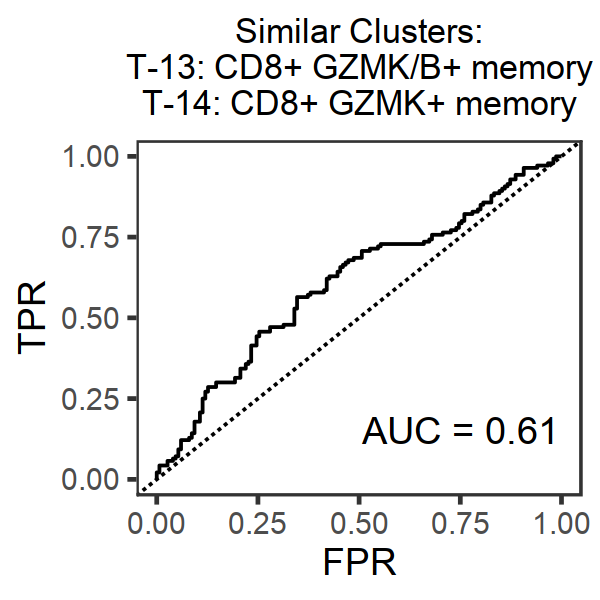

In [26]:
#Fig S14a left

options(repr.plot.height=5,repr.plot.width=5)
r <- AUROC_plots(LDA_sim,'Similar Clusters:\nT-13: CD8+ GZMK/B+ memory\nT-14: CD8+ GZMK+ memory')
g <- r$plot
df <- r$data
print(g)

if(!is.na(save_dir)){
    ggsave(file=paste(sep='',save_dir,CT,'_LDA_AUROC_sim',file_extension),
           plot=g,units='in',height=5,width=5,dpi=600)
    write.table(df,paste(sep='',save_dir,CT,'_LDA_AUROC_sim',data_extension),
                sep='\t',col.name=TRUE,row.name=FALSE,quote=FALSE)
}

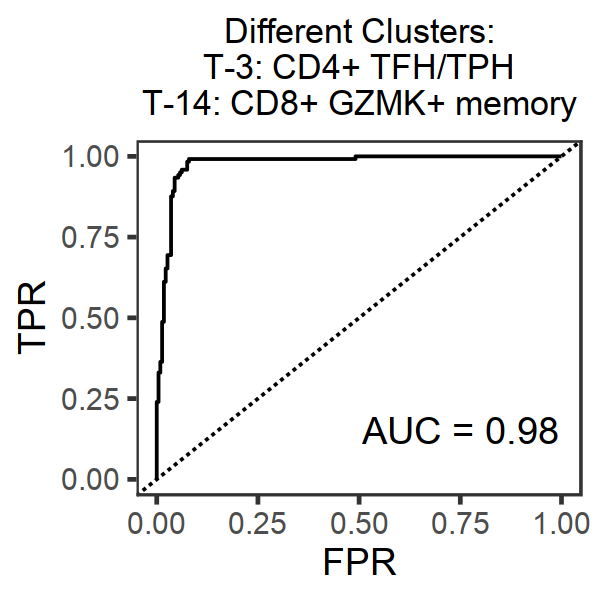

In [27]:
#Fig S14a right

options(repr.plot.height=5,repr.plot.width=5)
r <- AUROC_plots(LDA_dif,'Different Clusters:\nT-3: CD4+ TFH/TPH\nT-14: CD8+ GZMK+ memory')
g <- r$plot
df <- r$data
print(g)

if(!is.na(save_dir)){
    ggsave(file=paste(sep='',save_dir,CT,'_LDA_AUROC_dif',file_extension),
           plot=g,units='in',height=5,width=5,dpi=600)
    write.table(df,paste(sep='',save_dir,CT,'_LDA_AUROC_dif',data_extension),
                sep='\t',col.name=TRUE,row.name=FALSE,quote=FALSE)
}

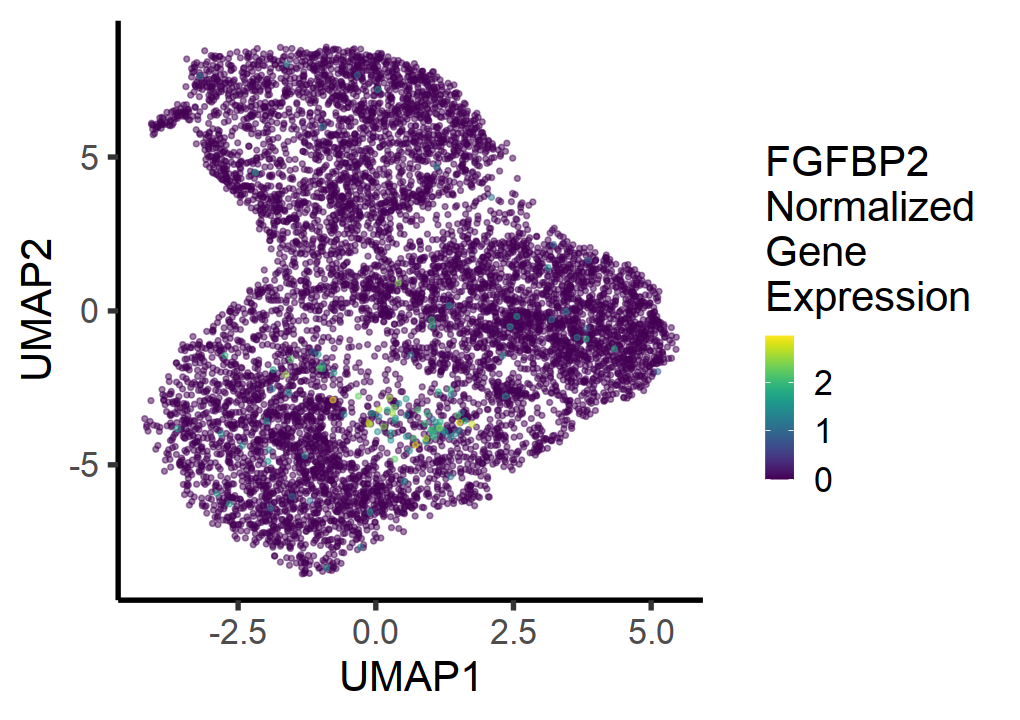

In [28]:
#Fig S11a left

gene_toPlot <- 'FGFBP2'
toPlot <- cbind(ATAC_meta[multiome_cells,],'gene'=snRNA_gxc_norm[gene_toPlot,multiome_cells])

options(repr.plot.height=6,repr.plot.width=8.5)
g <- ggplot(toPlot[order(toPlot$gene),],aes_string(x='UMAP1',y='UMAP2',color='gene')) + 
                geom_point(size=1,alpha=0.5) + 
                theme_classic(base_size=25) + scale_color_viridis(option = 'viridis') + 
                labs(color=paste(sep='',gene_toPlot,'\nNormalized\nGene\nExpression'))
print(g)

df <- toPlot[,c('UMAP1','UMAP2','gene')]
colnames(df) <- c('UMAP1','UMAP2',paste(gene_toPlot,'Normalized Gene Expression'))

if(!is.na(save_dir)){
    ggsave(file=paste(sep='',save_dir,CT,'_gene_',gene_toPlot,'_UMAP',file_extension),
           plot=g,units='in',height=6,width=8.5,dpi=600)
    write.table(df,paste(sep='',save_dir,CT,'_gene_',gene_toPlot,'_UMAP',data_extension),
                sep='\t',col.name=TRUE,row.name=FALSE,quote=FALSE)
}

### additional resolutions

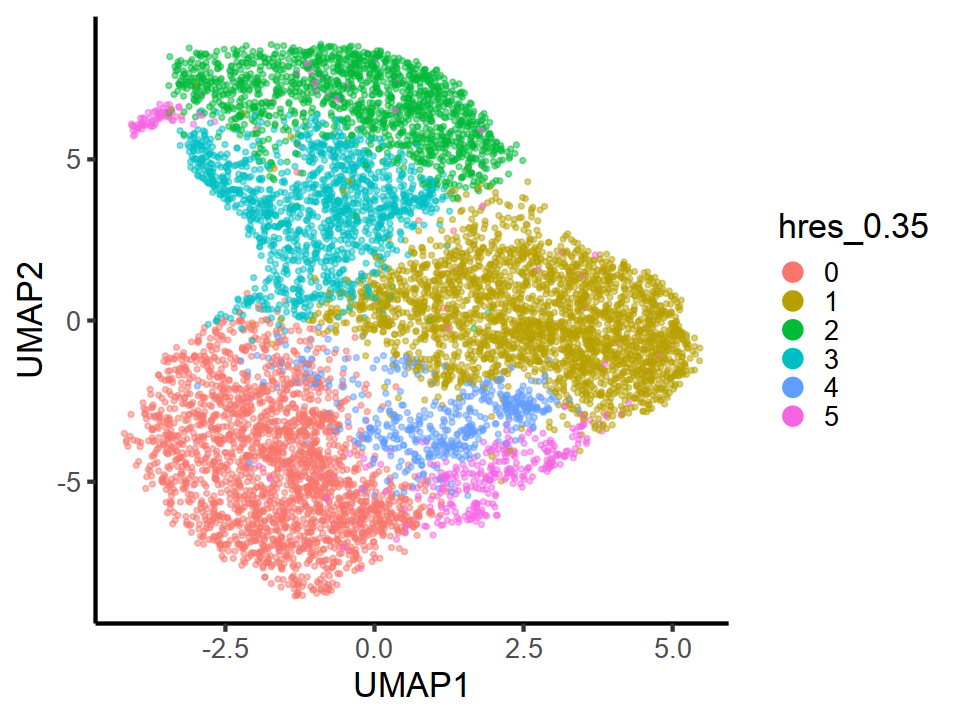

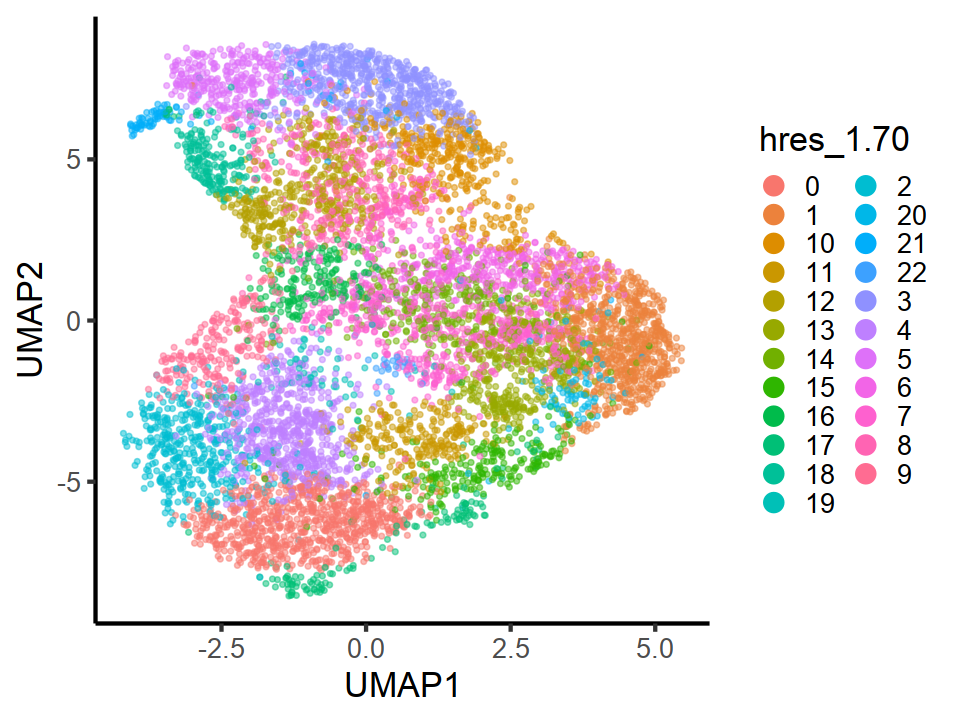

In [29]:
#Fig S13a top

if(!identical(sort(rownames(other_resol)),sort(rownames(ATAC_meta)))) stop('rownames need to be the same')
toPlot <- cbind(ATAC_meta,other_resol[rownames(ATAC_meta),])

for(cc in colnames(other_resol)){

    cluster_colors <- hue_pal()(length(unique(toPlot[,cc])))
    names(cluster_colors) <- sort(unique(toPlot[,cc]))

    options(repr.plot.height=6,repr.plot.width=8)
    g <- ggplot(toPlot[multiome_cells,],aes_string(x='UMAP1',y='UMAP2',color=cc)) + geom_point(size=1,alpha=0.5) + 
            theme_classic(base_size=20) + scale_color_manual(values=cluster_colors) + 
            guides(colour = guide_legend(override.aes = list(size=5,alpha=1)))
    print(g)
    
    df <- toPlot[multiome_cells,c('UMAP1','UMAP2',cc)]
    colnames(df) <- c('UMAP1','UMAP2',paste('RA',CT_label,cc))
    
    if(!is.na(save_dir)){
        ggsave(file=paste(sep='',save_dir,CT,'_ATAC_',cc,'_UMAP',file_extension),
               plot=g,units='in',height=6,width=8,dpi=600)
        write.table(df,paste(sep='',save_dir,CT,'_ATAC_',cc,'_UMAP',data_extension),
                    sep='\t',col.name=TRUE,row.name=FALSE,quote=FALSE)
    }
    
}

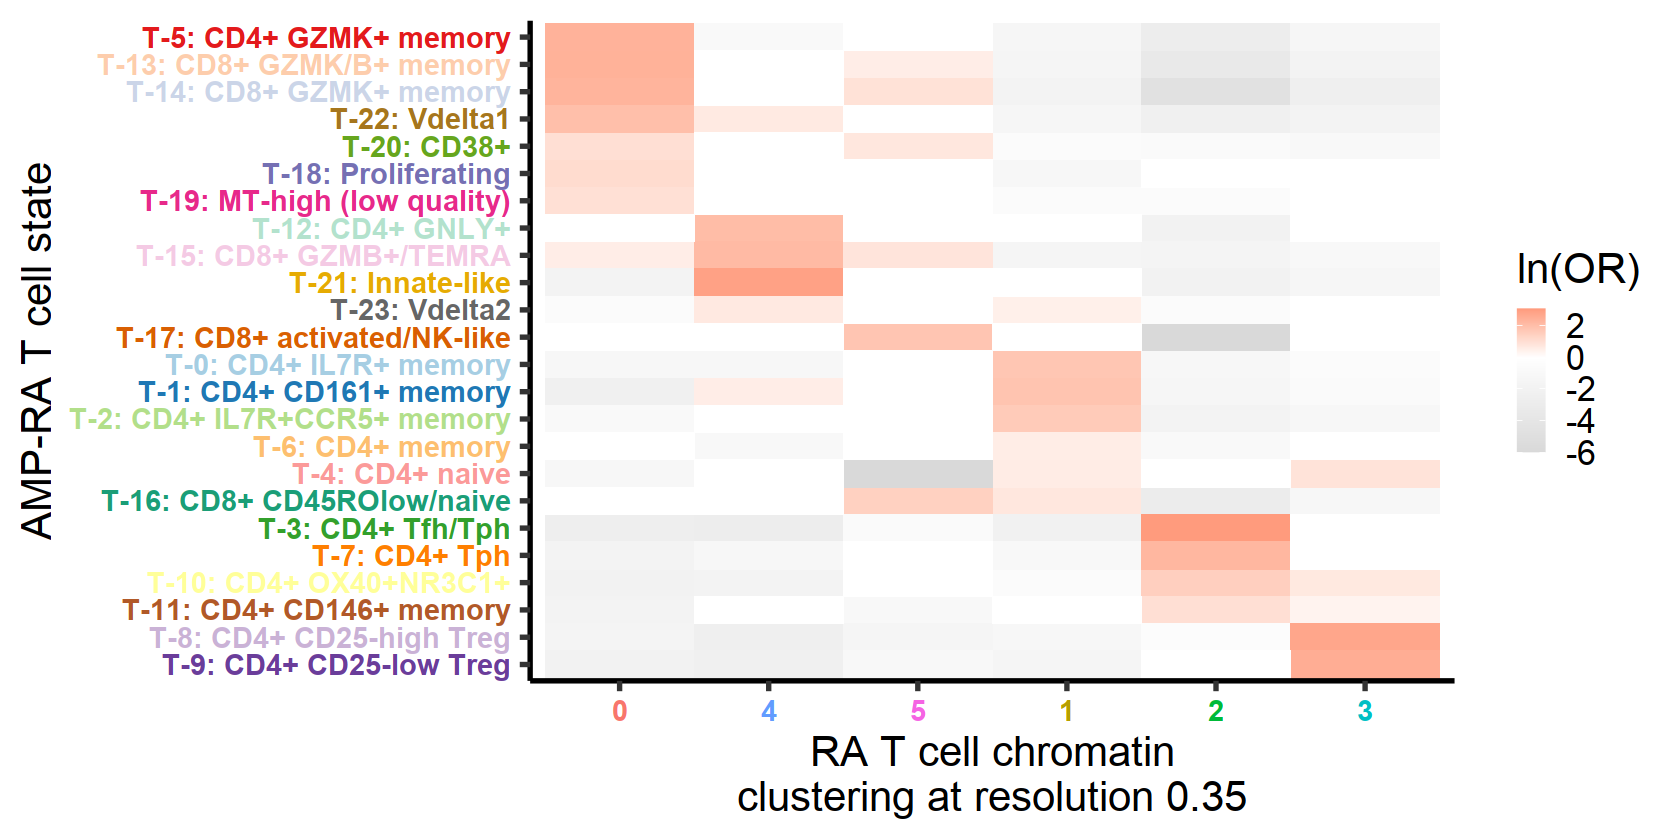

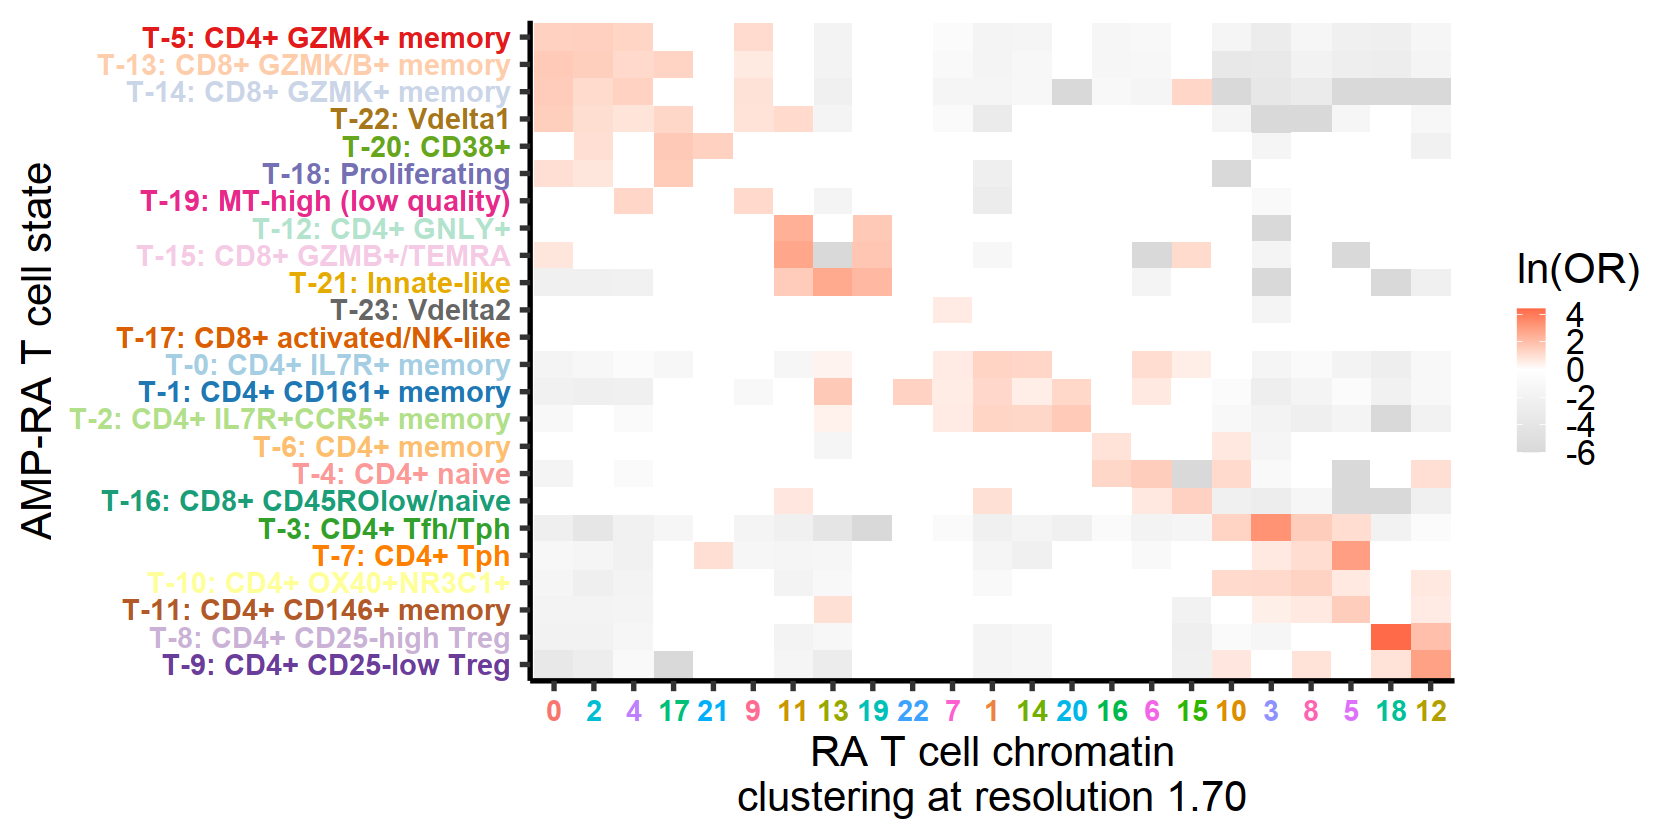

In [30]:
#Fig S13a bottom

if(!identical(sort(rownames(other_resol)),sort(rownames(ATAC_meta)))) stop('rownames need to be the same')
toPlot <- cbind(ATAC_meta,other_resol[rownames(ATAC_meta),])

for(cc in colnames(other_resol)){

    cluster_colors <- hue_pal()(length(unique(toPlot[,cc])))
    names(cluster_colors) <- sort(unique(toPlot[,cc]))
    
    fisher_df <- calc_OR(toPlot[multiome_cells,], cc, 'CITE')
    clustOrd <- reorder_col_diag_plotOR(fisher_df,cc,'CITE',yOrd=full_state_order,mCol='lnOR',op='max')

    g <- plot_OR(fisher_df, cc, 'CITE',
                 paste('RA',CT_label,'chromatin\nclustering at resolution',str_split_fixed(cc,'_',2)[,2]),
                 paste('AMP-RA',CT_label,'state'),
                 clustOrd, full_state_order,
                 clustColors=c(cluster_colors,CITE_colors))

    options(repr.plot.height=7,repr.plot.width=14)
    print(g)
    
    if(!is.na(save_dir)) ggsave(file=paste(sep='',save_dir,CT,'_',cc,'_state_OR_heatmap',file_extension),
                                plot=g,units='in',height=7,width=14,dpi=600)
}

## CITE donor proportions

Using 14 donors.


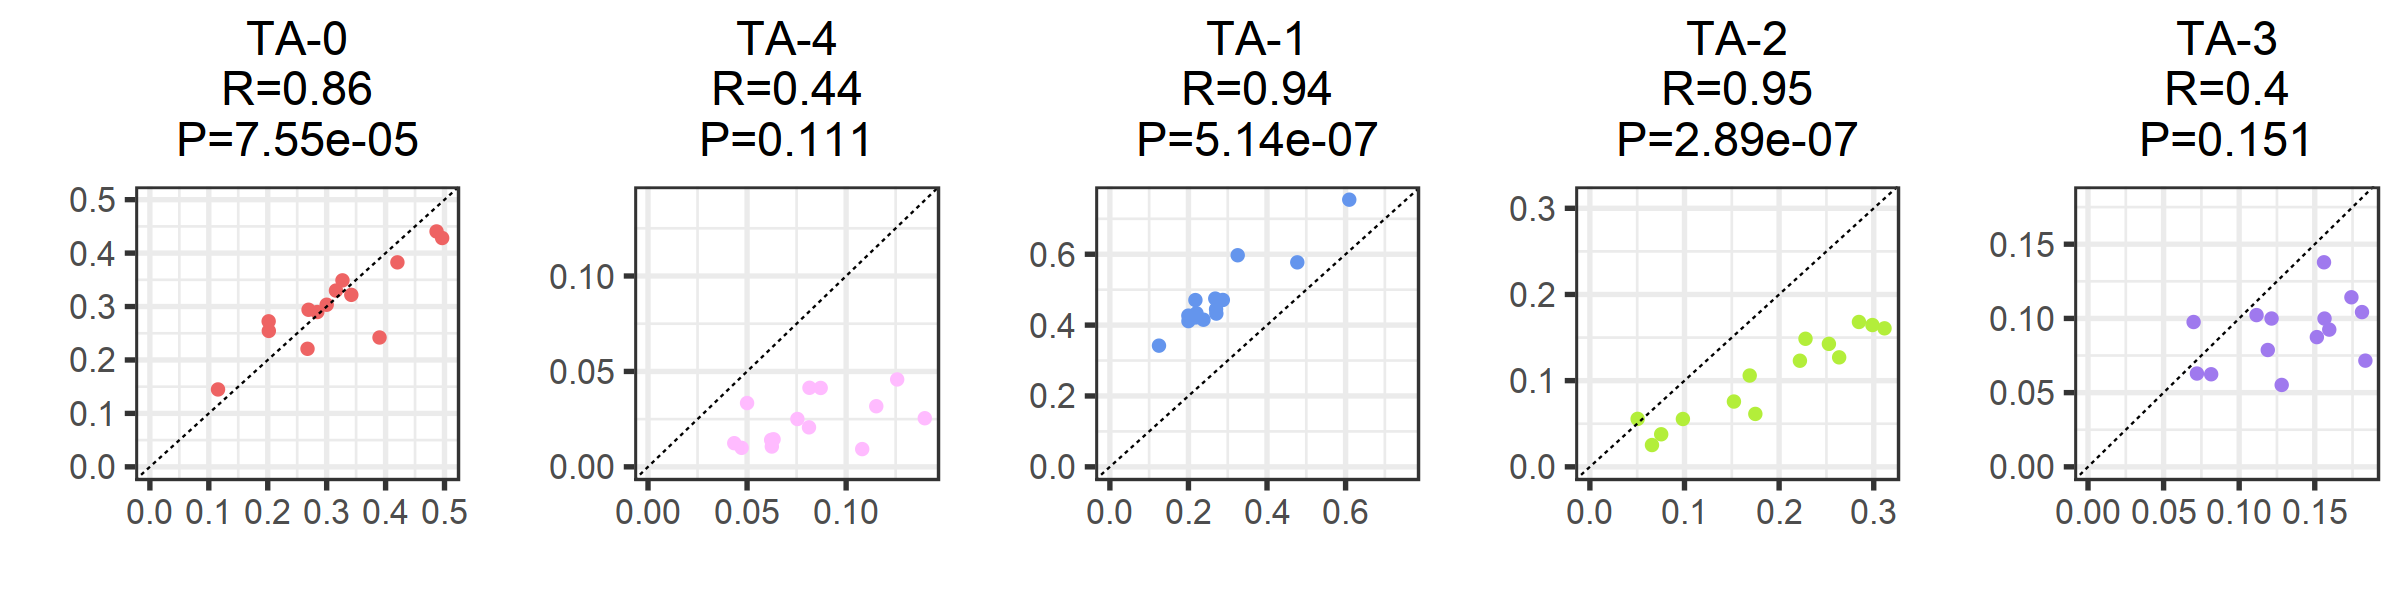

In [31]:
#Fig 8a

tVec <- sort(unique(ATAC_meta$cluster_abbr))
names(tVec) <- sort(unique(ATAC_meta$cluster_name))

options(repr.plot.height=5,repr.plot.width=4*length(unique(ATAC_meta$cluster_abbr)))
r <- donor_prop_comp_plot(ATAC_CITE_conv_df,ATAC_meta[which(ATAC_meta$assay=='scATAC'),],CITE_meta,
                          clustColors=ATAC_colors,tSize=28,tVec=tVec,aLab='',mLab='',
                          cs_order=full_class_order)
g <- r$plot
df <- r$data
grid.draw(g)

if(!is.na(save_dir)){
    ggsave(file=paste(sep='',save_dir,CT,'_ATAC_CITE_donor_prop',file_extension),
           plot=g,units='in',height=5,width=4*length(unique(ATAC_meta$cluster_abbr)),dpi=600)
    write.table(df,paste(sep='',save_dir,CT,'_ATAC_CITE_donor_prop',data_extension),
                sep='\t',col.name=TRUE,row.name=FALSE,quote=FALSE)
}

## CNA associations

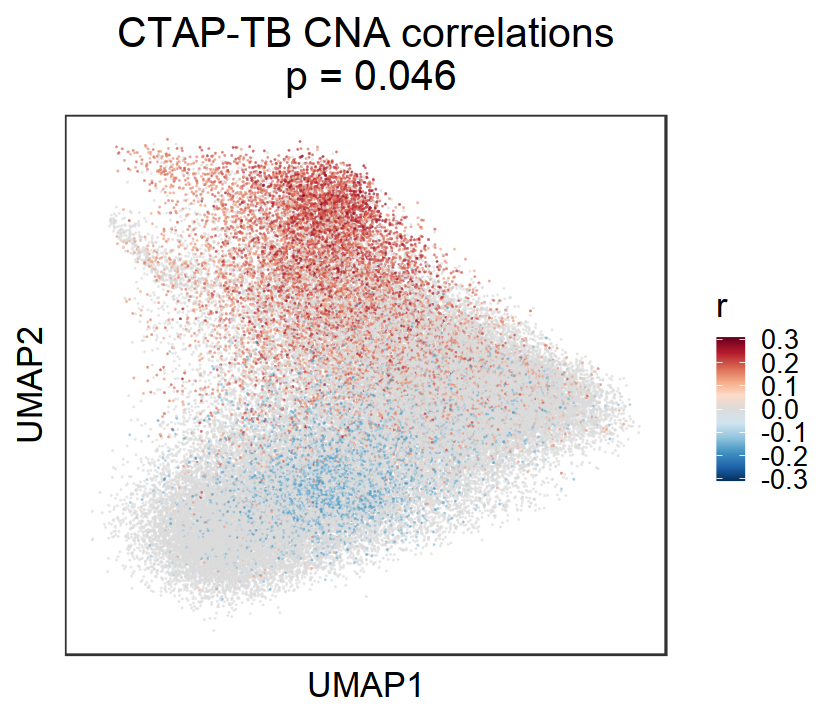

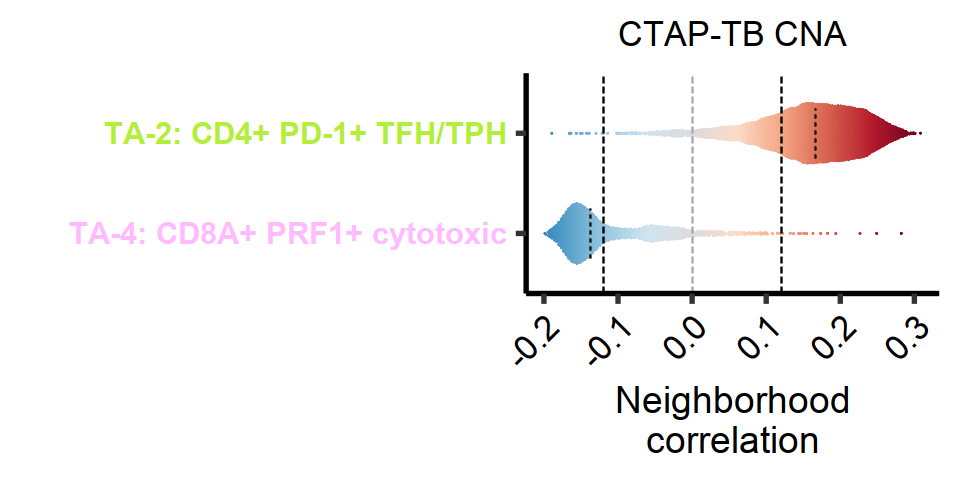

In [32]:
#Fig 8c

CNA_TB_FDR <- 0.12
CNA_TB_globalp <- 0.046
CNA_title <- 'CTAP-TB'
CNA_col <- 'cna_corr_TB'
class_col <- 'ATAC_cluster_name'

toPlot <- CNA_add_col(CITE_meta, CNA_TB, CNA_col)

options(repr.plot.height=6,repr.plot.width=7)
r <- CNA_umap_plots(toPlot,'ATAC_UMAP1','ATAC_UMAP2',CNA_col,
                    thisTitle=paste(CNA_title,'CNA correlations\n','p =',CNA_TB_globalp),
                    smallPt=TRUE,fdr_thresh=CNA_TB_FDR)
g <- r$plot
df <- r$data
print(g)
if(!is.na(save_dir)){
    ggsave(file=paste(sep='',save_dir,CT,'_',str_replace(CNA_title,' ','_'),'_CNA_UMAP',file_extension),
           plot=g,units='in',height=6,width=7,dpi=600)
    write.table(df,paste(sep='',save_dir,CT,'_',str_replace(CNA_title,' ','_'),'_CNA_UMAP',data_extension),
                sep='\t',col.name=TRUE,row.name=FALSE,quote=FALSE)
}

#only plot those classes whose median is above FDR thresholds
ll <- aggregate(toPlot[,CNA_col] ~ toPlot[,class_col], FUN=median)
colnames(ll) <- c(class_col,CNA_col)
CNA_classes <- ll[which(abs(ll[,CNA_col])>CNA_TB_FDR),class_col]


options(repr.plot.height=4,repr.plot.width=8)
g <- CNA_violin_plots(toPlot[which(toPlot[,class_col] %in% CNA_classes),],
                      class_col,CNA_col,CNA_TB_FDR,thisTitle=paste(CNA_title,'CNA'),clustColors=ATAC_colors)
print(g)
if(!is.na(save_dir)) ggsave(file=paste(sep='',save_dir,CT,'_',str_replace(CNA_title,' ','_'),'_CNA_violin',file_extension),
                                plot=g,units='in',height=4,width=8,dpi=600)

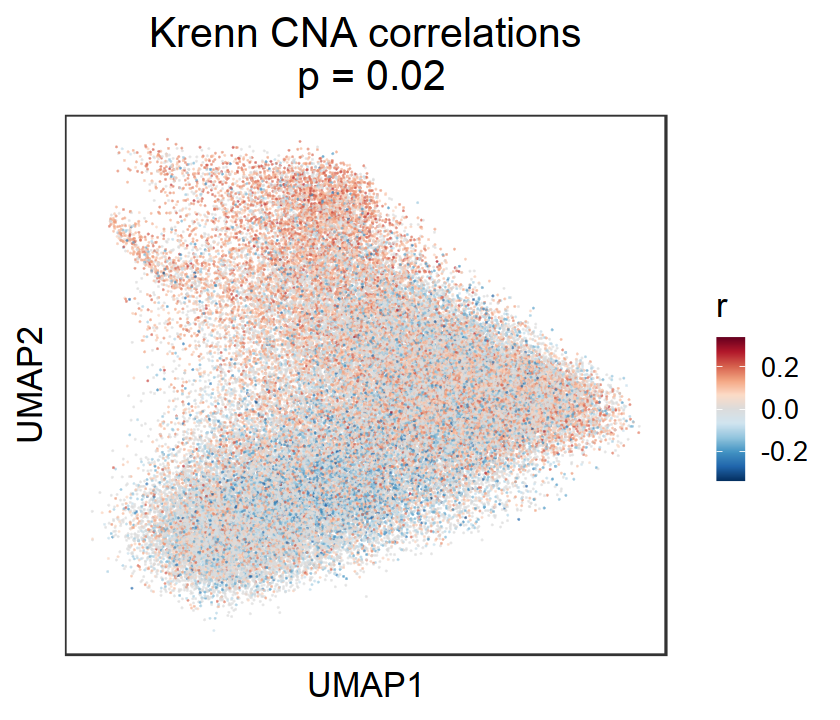

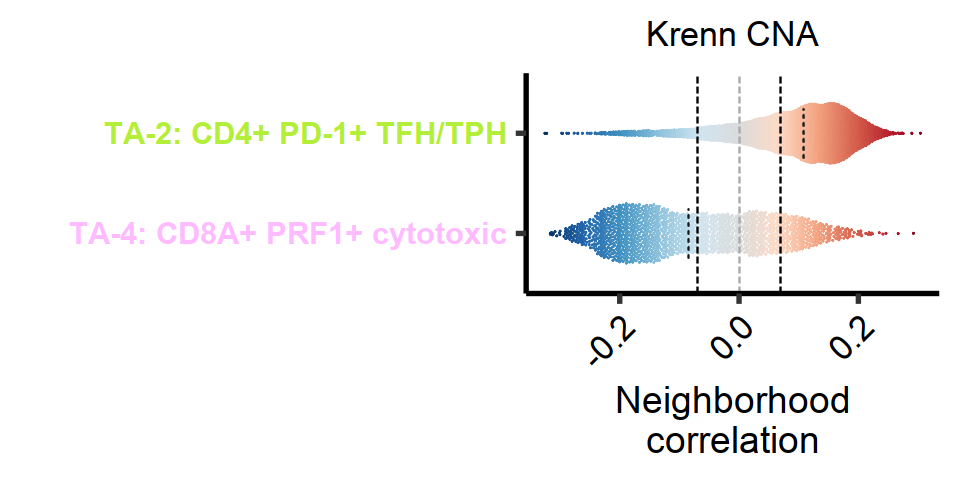

In [33]:
#Fig S16b

CNA_KI_FDR <- 0.07
CNA_KI_globalp <- 0.02
CNA_title <- 'Krenn'
CNA_col <- 'cna_corr_krenn'
class_col <- 'ATAC_cluster_name'

toPlot <- CNA_add_col(CITE_meta, CNA_KI, CNA_col)

options(repr.plot.height=6,repr.plot.width=7)
r <- CNA_umap_plots(toPlot,'ATAC_UMAP1','ATAC_UMAP2',CNA_col,
                    thisTitle=paste(CNA_title,'CNA correlations\n','p =',CNA_KI_globalp),
                    smallPt=TRUE,fdr_thresh=CNA_KI_FDR)
g <- r$plot
df <- r$data
print(g)
if(!is.na(save_dir)){
    ggsave(file=paste(sep='',save_dir,CT,'_',str_replace(CNA_title,' ','_'),'_CNA_UMAP',file_extension),
           plot=g,units='in',height=6,width=7,dpi=600)
    write.table(df,paste(sep='',save_dir,CT,'_',str_replace(CNA_title,' ','_'),'_CNA_UMAP',data_extension),
                sep='\t',col.name=TRUE,row.name=FALSE,quote=FALSE)
}

#only plot those classes whose median is above FDR thresholds
ll <- aggregate(toPlot[,CNA_col] ~ toPlot[,class_col], FUN=median)
colnames(ll) <- c(class_col,CNA_col)
CNA_classes <- ll[which(abs(ll[,CNA_col])>CNA_KI_FDR),class_col]


options(repr.plot.height=4,repr.plot.width=8)
g <- CNA_violin_plots(toPlot[which(toPlot[,class_col] %in% CNA_classes),],
                      class_col,CNA_col,CNA_KI_FDR,thisTitle=paste(CNA_title,'CNA'),clustColors=ATAC_colors)
print(g)
if(!is.na(save_dir)) ggsave(file=paste(sep='',save_dir,CT,'_',str_replace(CNA_title,' ','_'),'_CNA_violin',file_extension),
                                plot=g,units='in',height=4,width=8,dpi=600)

## Session Info

In [34]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/kew47/miniconda3/lib/R/lib/libRblas.so

locale:
[1] en_US.UTF-8

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] repr_1.0.1         gridExtra_2.3      RColorBrewer_1.1-2 scales_1.1.1      
 [5] viridis_0.5.1      viridisLite_0.3.0  ggrepel_0.8.2      ggrastr_0.2.3     
 [9] tidyr_1.0.3        stringr_1.4.0      ggpubr_0.4.0       ggplot2_3.3.0     
[13] presto_1.0.0       Rcpp_1.0.4.6       ROCR_1.0-7         gplots_3.0.1.1    
[17] Rmisc_1.5.1        plyr_1.8.6         lattice_0.20-41    gtools_3.8.2      
[21] Matrix_1.2-18     

loaded via a namespace (and not attached):
 [1] jsonlite_1.7.1      carData_3.0-4       vipor_0.4.5        
 [4] cellranger_1.1.0    pillar_1.4.4        backports_1.1.6    
